##Neural Network-Based Image Prediction: Bridging the Gap Between Neuronal Responses and Visual Reconstructions

##Class: Computational Perception - 15-786 - F23
##Name: Jared Cohen
##Andrew ID: jaredcoh
##Date: 12/3/23


Comments from the creator:
- As described in the paper, Models 1 and 3 (and Models 2 and 4) match Loss Functions. Models 1 and 2 (and Models 3 and 4) match information flow architectures.
- All images and weights are saved on the Google Drive. If you are looking to run each model and visualize data analysis/statistics using the pre-trained data. ONLY CLICK PLAY ON THE SECTIONS WITH "*" AT THE FRONT. Blocks without stars may have sections inside with stars. Sections with stars imply all sections inside have stars (and thus can just be clicked to run all at once)
- Provided model "Shared Core Model" is based on a 2017 NIPS paper
`https://proceedings.neurips.cc/paper/2017/file/8c249675aea6c3cbd91661bbae767ff1-Paper.pdf`

#*Dependencies


In [ ]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p '15387'
%cd /content/drive/MyDrive/15387/Project
#git clone https://github.com/leelabcnbc/neuron_in_silicon.git
%cd /content/drive/MyDrive/15387/Project/neuron_in_silicon


Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/15387/Project
/content/drive/MyDrive/15387/Project/neuron_in_silicon


In [ ]:
!pip install pytictoc
!pip install imshowtools

In [ ]:
import os
import gc
import cv2
import PIL
import sys
import copy
import time
import torch
import imshowtools
import numpy as np
import torch.nn as nn
from pytictoc import TicToc
import torch.optim as optim
from scipy.stats import skew
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.signal import correlate2d
from skimage.io import imread, imsave
from scipy.stats import skew, pearsonr
from matplotlib.animation import FuncAnimation
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

%cd /content/drive/MyDrive/15387/Project/neuron_in_silicon/functions
sys.path.append('/content/drive/MyDrive/15387/Project/neuron_in_silicon/')
from visualize_SharedCore import visualize_neuron_single
from bethge import BethgeModel
from GS_functions import GF
%cd /content/drive/MyDrive/15387/Project/neuron_in_silicon/
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t=TicToc()

main_savepath=GF.mkdir('./','Results')

/content/drive/MyDrive/15387/Project/neuron_in_silicon/functions
/content/drive/MyDrive/15387/Project/neuron_in_silicon
folder existed


#### This is the provided model (from HW3)

In [ ]:
channels = 256
num_layers = 9
input_size = 50
output_size = 302
first_k = 9
later_k = 3
pool_size = 2
factorized = True
num_maps = 1
net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).to(device)
net.to(device)
net.load_state_dict(torch.load('models/9_10_m1s1_shared_core_256_9',map_location=device))
net.eval()

BethgeModel(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1, threshold=20)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Softplus(beta=1

#Getting Required Data


##Acquiring 34,000 Pre-Processed Images from Online Website

In [ ]:
import requests
import numpy as np

# URL of file location
url = "https://www.ni.cmu.edu/~tai/cp_public/train_img_m1s1.npy"

# Send a GET request to the URL
print("Getting Response")
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    print("Response Successful")

    # Save the file in the Colab environment
    with open("train_img_m1s1.npy", "wb") as f:
        f.write(response.content)
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


Getting Response
Response Successful


## *Load Images From Stored File


Shape of the Data: (34000, 50, 50, 1)
Shape of the array: (34000, 1, 50, 50)


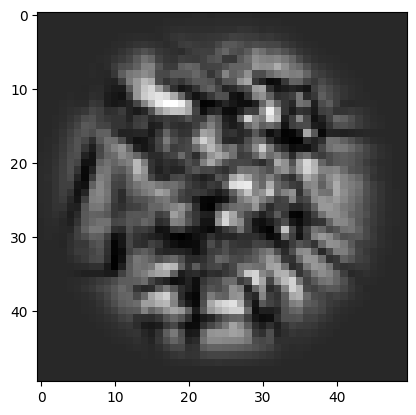

In [ ]:
#Data was stored in numpy file on Colab
data = np.load("train_img_m1s1.npy")

# Print the shape of the array
print("Shape of the Data:",data.shape)

#Print First Image
real_rsp_pair_pics = data.reshape(34000, 1, 50, 50)
plt.imshow(real_rsp_pair_pics[0][0], cmap = 'gray')

#Print Shape of Array (should be 50x50)
print("Shape of the array:",real_rsp_pair_pics.shape)


## Get Responses from Images

In [ ]:
#Get model responses
val_predict_rsp = GF.get_model_rsp(net, real_rsp_pair_pics, batch_size = 512, device=device, norm_1=0)

# shape = (num_images, num_neurons)
print("Shape of Responses", val_predict_rsp.shape)

NameError: ignored

##Saving the Neuronal Responses

In [ ]:
file_path = '/content/drive/MyDrive/15387/Project/neuron_in_silicon/val_predict_rsp.npy'

if os.path.exists(file_path):

    # Load the variable from the file using numpy
    loaded_val_predict_rsp = np.load(file_path)
    print("Variable loaded successfully.")

else:
    print(f"File '{file_path}' does not exist. Creating a new file.")

    # Save the variable to a new file using numpy
    np.save(file_path, val_predict_rsp)
    print(f"Variable saved to '{file_path}'.")

##*Loading the Neuronal Responses

In [ ]:
file_path = '/content/drive/MyDrive/15387/Project/neuron_in_silicon/val_predict_rsp.npy'

if os.path.exists(file_path):

    # Load the variable from the file using numpy
    val_predict_rsp = np.load(file_path)
    print("Variable loaded successfully.")
    print(val_predict_rsp.shape)
else:
    print(f"File '{file_path}' does not exist.")

Variable loaded successfully.
(34000, 302)


#*Setting up Training and Test Data

In [ ]:
#training size was determined to be 25000 images, testing is 9000 (26.5% is Test Data)
training_size = 25000
#Training Neuron Responses are Stored in Y
X = val_predict_rsp[0:training_size]
print("Training Responses", X.shape)

#Training Targe Images are stored in Y
Y = real_rsp_pair_pics[0:training_size].squeeze().reshape((training_size, 2500))
print("Training Flattened Images", Y.shape)

Training Responses (25000, 302)
Training Flattened Images (25000, 2500)


#Neural Network Model 1 - Full Layer Perception with Loss by Pixel-by-Pixel Values

##*Define Model Architecture

In [ ]:
#Sequential Architecture
#1 input (302) --> 2 hidden --> 1 output (2500)
model1 = nn.Sequential(
    nn.Linear(302, 500),
    nn.ReLU(),
    nn.Linear(500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 2000),
    nn.ReLU(),
    nn.Linear(2000, 2500),
    nn.Sigmoid())

#Loss = Mean Squared error Loss
loss_fn = nn.MSELoss()

#Optimizer = Adam (generic)
optimizer = optim.Adam(model1.parameters(), lr=0.001)

#Important Hyper Parameters
n_epochs = 100
batch_size = 100

##*Load Pre-Trained if Not Training

In [ ]:
model1.load_state_dict(torch.load('models/M1_100epo_100batch_25ktrain.pth'))

<All keys matched successfully>

##Model 1 Training Algorithmm

In [ ]:
#Holds Loss Values to Visualize loss as Training
loss_values = []

for epoch in range(n_epochs):

    #For Timing
    start = time.time()

    for i in range(0, len(X), batch_size):

        #Used to track progress
        if i %1000 == 0:
          print(i, "\r", flush = True)

        #Gets Batch of Responses
        Xbatch = torch.from_numpy(X[i:i+batch_size].astype(np.float32))

        #Gets Batch of Images
        ybatch = torch.from_numpy(Y[i:i+batch_size].astype(np.float32))

        #Passes Responses through model
        y_pred = model1(Xbatch)

        optimizer.zero_grad()

        #Loss Function takes in Images
        loss = loss_fn(y_pred,ybatch)
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())

    #Plots Images after each Epoch
    if epoch %1 == 0:
      plt.figure(figsize=(6, 2))
      plt.subplot(2, 3, 1)
      plt.imshow(model1(torch.from_numpy(X[0])).detach().numpy().reshape(50, 50))
      plt.axis('off')
      plt.subplot(2, 3, 2)
      plt.imshow(Y[0].reshape(50, 50))
      plt.axis('off')
      plt.subplot(2, 3, 3)
      plt.plot(loss_values)
      plt.show()
      plt.figure(figsize=(6, 2))
      plt.subplot(2, 3, 4)
      plt.imshow(model1(torch.from_numpy(X[1])).detach().numpy().reshape(50, 50))
      plt.axis('off')
      plt.subplot(2, 3, 5)
      plt.imshow(Y[1].reshape(50, 50))
      plt.axis('off')

    #Provides relevant information at end of each epoch
    print(f'Finished epoch {epoch}, latest loss {loss}, time {time.time() - start}')

#Plots at end of training
with torch.no_grad():
  y_pred = model1(torch.from_numpy(X[0])).detach().numpy()

  plt.plot(range(len(loss_values)), loss_values)
  plt.show()
  plt.imshow(y_pred.reshape(50, 50))
  plt.axis('off')
  plt.show()
  plt.imshow(Y[0].reshape(50, 50))
  plt.axis('off')
  plt.show()

0 
1000 
2000 
3000 


KeyboardInterrupt: ignored

##Save Model Parameters after Training

In [ ]:
torch.save(model1.state_dict(), 'models/M1_100epo_100batch_25ktrain.pth')

#Neural Network Model 2 - Full Layer Perception with Preceptual Loss


##*Define Model Architecture and Hyper Parameters

In [ ]:
#same as number 1
model2 = nn.Sequential(
    nn.Linear(302, 500),
    nn.ReLU(),
    nn.Linear(500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 2000),
    nn.ReLU(),
    nn.Linear(2000, 2500),
    nn.Sigmoid())

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
n_epochs = 10
batch_size = 100

torch.cuda.empty_cache()


##*Load if not training

In [ ]:
model2.load_state_dict(torch.load('models/M2_10epo_100batch_25ktrain.pth', map_location = device))

<All keys matched successfully>

##Training Algorithm

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


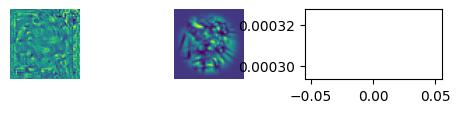

Finished epoch 0, latest loss 0.00031053845304995775, time 172.66260313987732
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


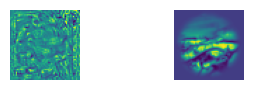

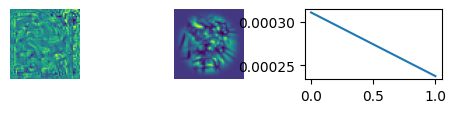

Finished epoch 1, latest loss 0.00023769184190314263, time 172.44895482063293
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


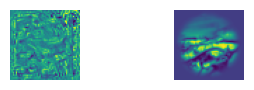

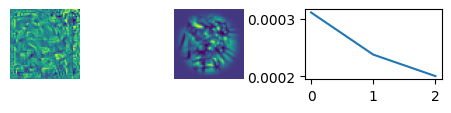

Finished epoch 2, latest loss 0.00020053447224199772, time 172.67774081230164
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


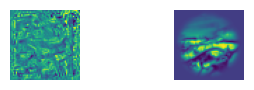

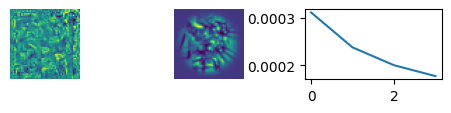

Finished epoch 3, latest loss 0.0001778135192580521, time 172.72665858268738
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


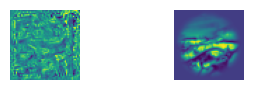

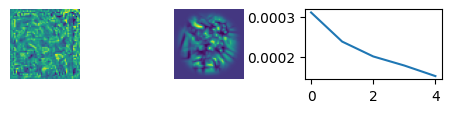

Finished epoch 4, latest loss 0.0001513820025138557, time 172.69863629341125
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


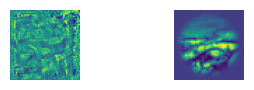

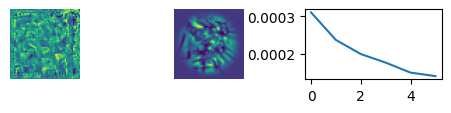

Finished epoch 5, latest loss 0.0001421932684024796, time 172.42125272750854
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


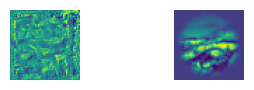

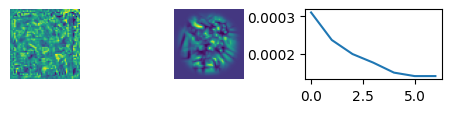

Finished epoch 6, latest loss 0.00014221436867956072, time 172.65825986862183
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


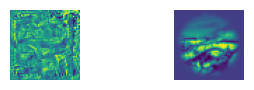

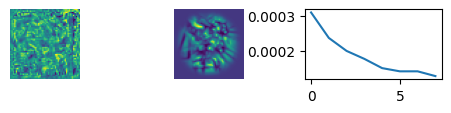

Finished epoch 7, latest loss 0.00012858070840593427, time 172.8685221672058
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


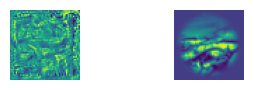

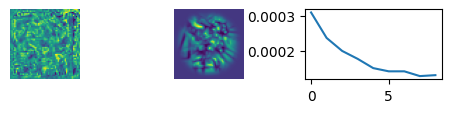

Finished epoch 8, latest loss 0.00013126306293997914, time 172.44990825653076
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


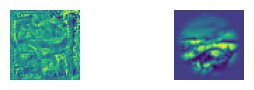

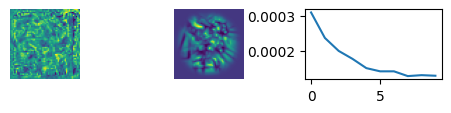

Finished epoch 9, latest loss 0.00012959585001226515, time 172.45996570587158


TypeError: ignored

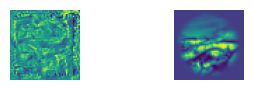

In [ ]:
loss_values = []

for epoch in range(n_epochs):
    start = time.time()
    for i in range(0, len(X), batch_size):
        if i%1000==0:
          print(i)
        Xbatch = torch.from_numpy(X[i:i+batch_size].astype(np.float32)).cuda()
        ybatch = torch.from_numpy(Y[i:i+batch_size].astype(np.float32)).cuda()
        model2 = model2.to(device=Xbatch.device)
        y_pred = model2(Xbatch)
        pred_response = net(y_pred.reshape(batch_size,1,50,50))
        optimizer.zero_grad()

        #key difference is loss function inputs --> responses, not images
        loss = loss_fn(pred_response, Xbatch)

        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch %1 == 0:
      plt.figure(figsize=(6, 2))
      plt.subplot(2, 3, 1)
      plt.imshow(model2(torch.from_numpy(X[0]).cuda()).detach().cpu().numpy().reshape(50, 50))
      plt.axis('off')
      plt.subplot(2, 3, 2)
      plt.imshow(Y[0].reshape(50, 50))
      plt.axis('off')
      plt.subplot(2, 3, 3)
      plt.plot(loss_values)
      plt.show()
      plt.figure(figsize=(6, 2))
      plt.subplot(2, 3, 4)
      plt.imshow(model2(torch.from_numpy(X[1]).cuda()).detach().cpu().numpy().reshape(50, 50))
      plt.axis('off')
      plt.subplot(2, 3, 5)
      plt.imshow(Y[1].reshape(50, 50))
      plt.axis('off')

    print(f'Finished epoch {epoch}, latest loss {loss}, time {time.time() - start}')

with torch.no_grad():
  y_pred = model2(torch.from_numpy(X[0]).cuda()).detach().cpu().numpy()

  plt.plot(range(n_epochs), loss_values)
  plt.show()
  plt.imshow(y_pred.reshape(50, 50))
  plt.axis('off')
  plt.show()
  plt.imshow(Y[0].reshape(50, 50))
  plt.axis('off')
  plt.show()

##Save the Model

In [ ]:
torch.save(model2.state_dict(), 'models/M2_10epo_100batch_25ktrain.pth')
#to load
#loaded_model.load_state_dict(torch.load(model_path))

#Neural Network Model 3 - Convolutional Neural Network with Loss by Pixel-by-Pixel Values

##*Define Model Architecutre

In [ ]:
#custom defined neural network
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Linear layers to map input (302) to 2048
        self.fc1 = nn.Linear(302, 1024)
        self.fc2 = nn.Linear(1024, 2048)

        # Convolutional layers --> divide number of channels by 2 while upsampling each channel size by 2
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2= nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv4 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.upsample4 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv5 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.upsample5 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv6 = nn.Conv2d(4, 2, kernel_size=3, stride=1, padding=1)
        self.upsample6 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv7 = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1)
        self.upsample7 = nn.Upsample(scale_factor=2, mode='bicubic')

    def forward(self, x):
        # Linear layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Reshape to (1, 4, 4, 128)
        x = x.view(x.shape[0], 128, 4, 4)
        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.upsample4(x)
        x = torch.relu(self.conv5(x))
        x = self.upsample5(x)
        x = torch.relu(self.conv6(x))
        x = self.upsample6(x)
        x = torch.relu(self.conv7(x))
        x = self.upsample7(x)
        return x

# Create an instance of the model
model3 = CustomCNN()

# Loss function and optimizer
loss_fn = nn.MSELoss()

optimizer = optim.Adam(model3.parameters(), lr=0.001)

# Training parameters
n_epochs = 100
batch_size = 1000



##*Load Model if Not Training

In [ ]:
model3.load_state_dict(torch.load('models/M3_200epo_1000batch_25ktrain.pth', map_location = device))

<All keys matched successfully>

##Training Loop

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


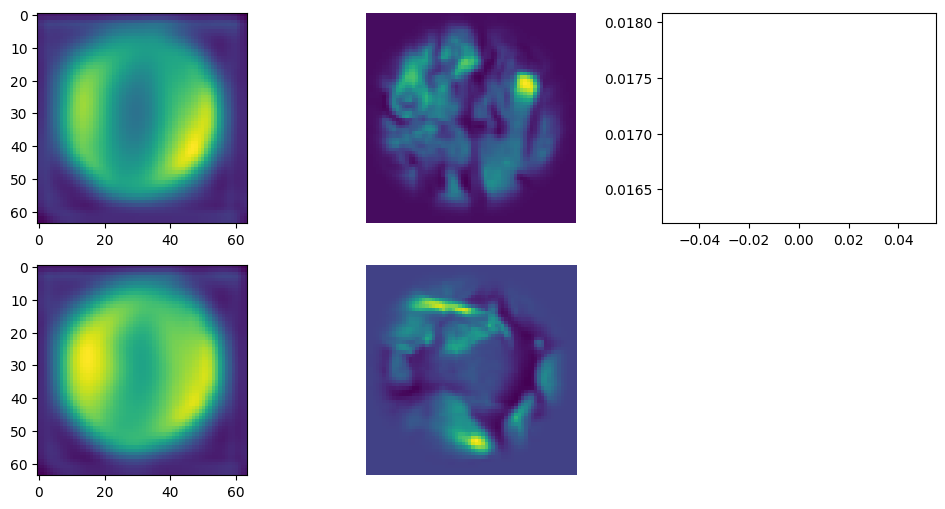

Finished epoch 0, latest loss 0.01713697984814644, time 38.649986743927
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


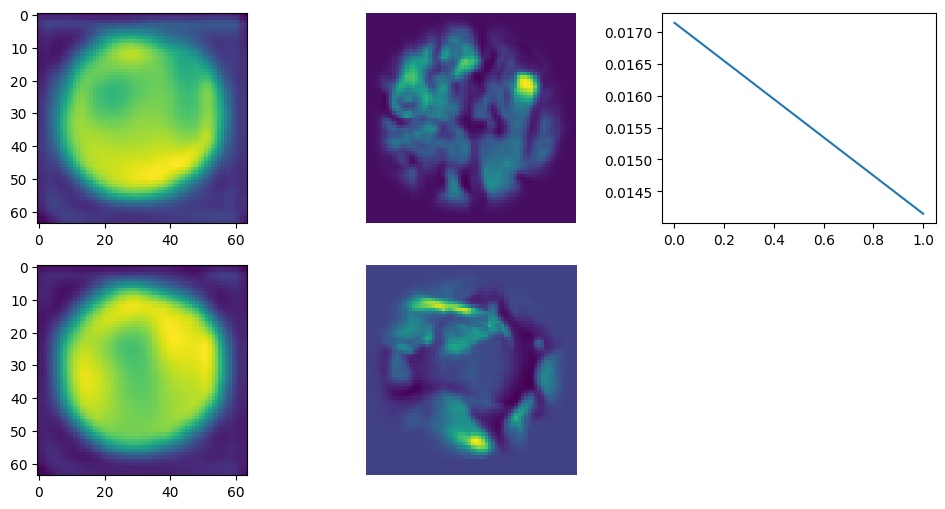

Finished epoch 1, latest loss 0.014151716604828835, time 36.173548221588135
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


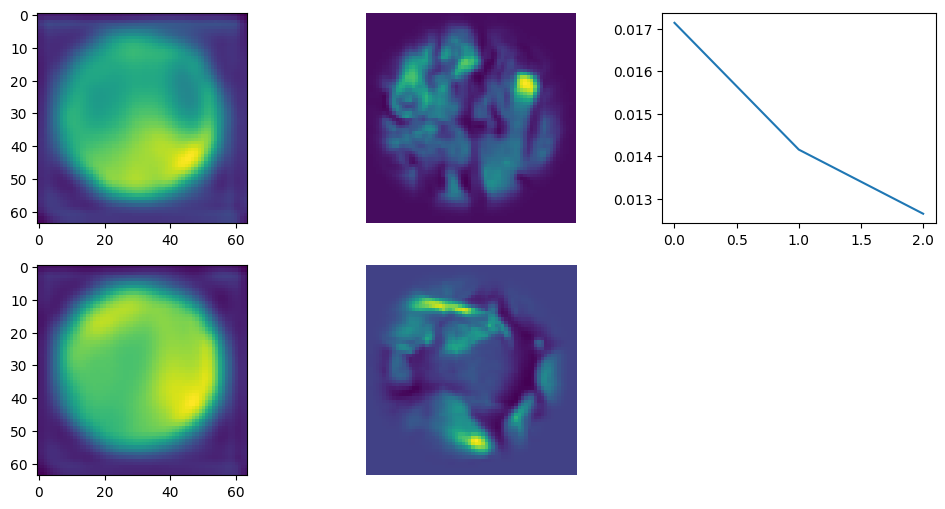

Finished epoch 2, latest loss 0.01264223549515009, time 37.99173426628113
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


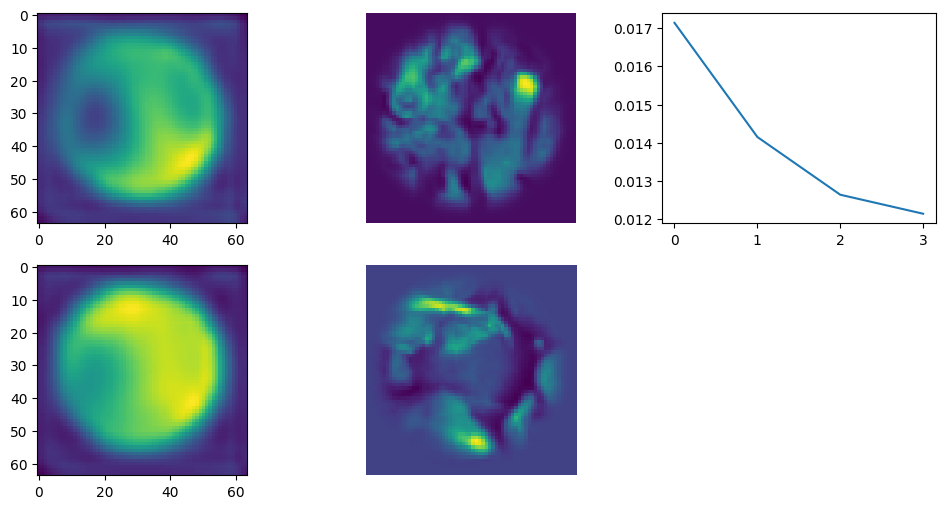

Finished epoch 3, latest loss 0.012145372107625008, time 37.05736494064331
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


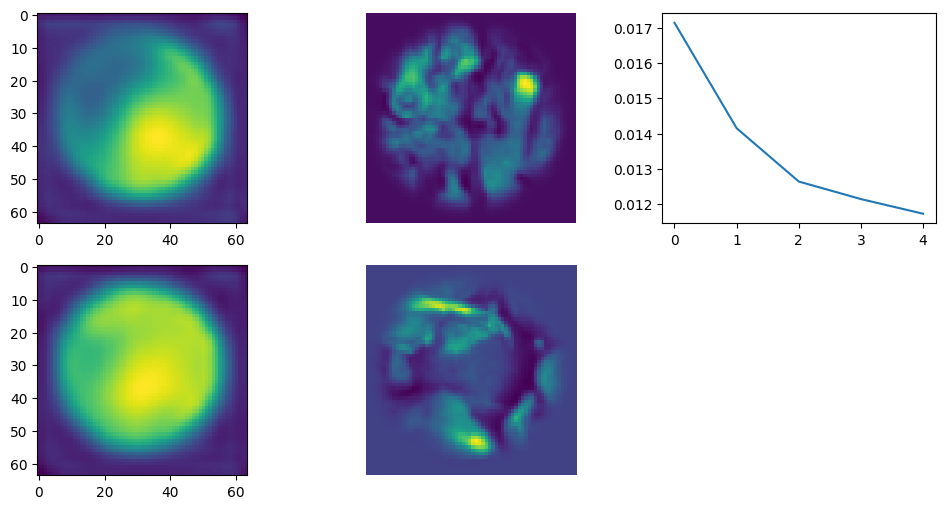

Finished epoch 4, latest loss 0.011730805039405823, time 35.976561546325684
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


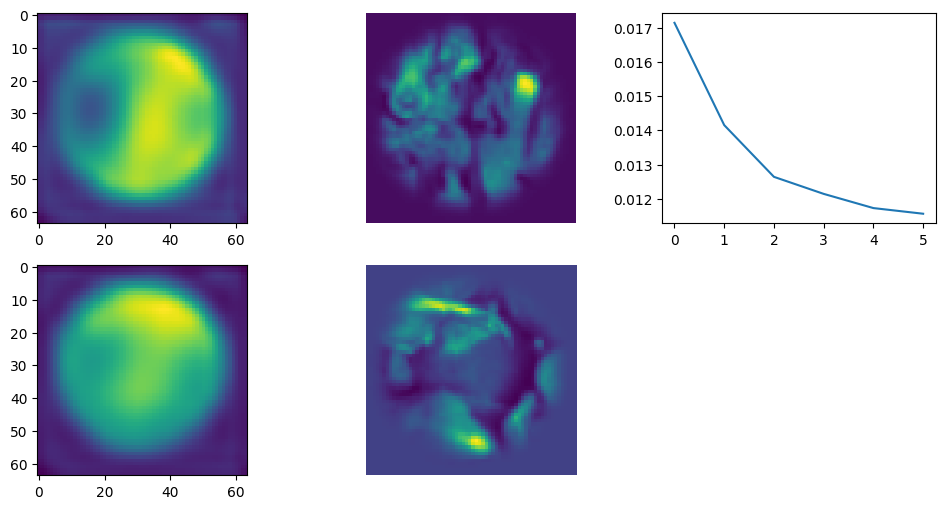

Finished epoch 5, latest loss 0.011565961875021458, time 36.155274629592896
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


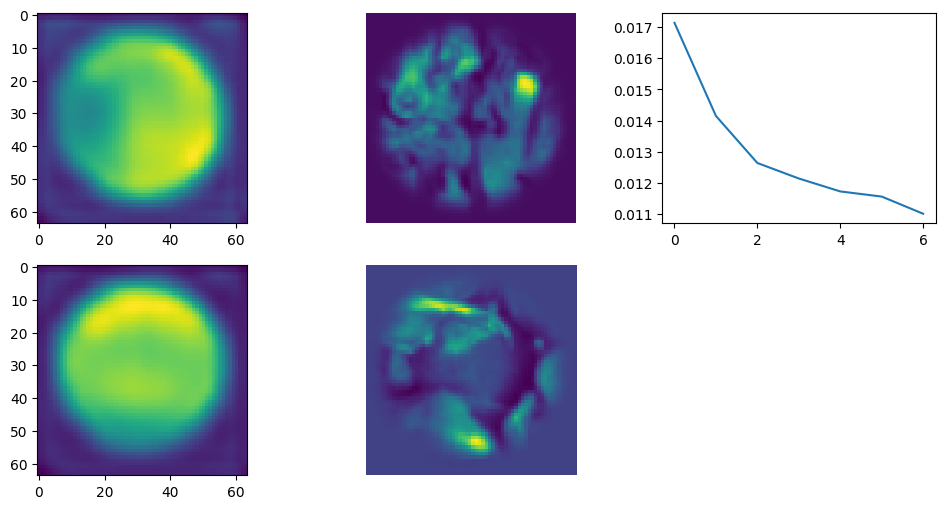

Finished epoch 6, latest loss 0.011015588417649269, time 39.32293224334717
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


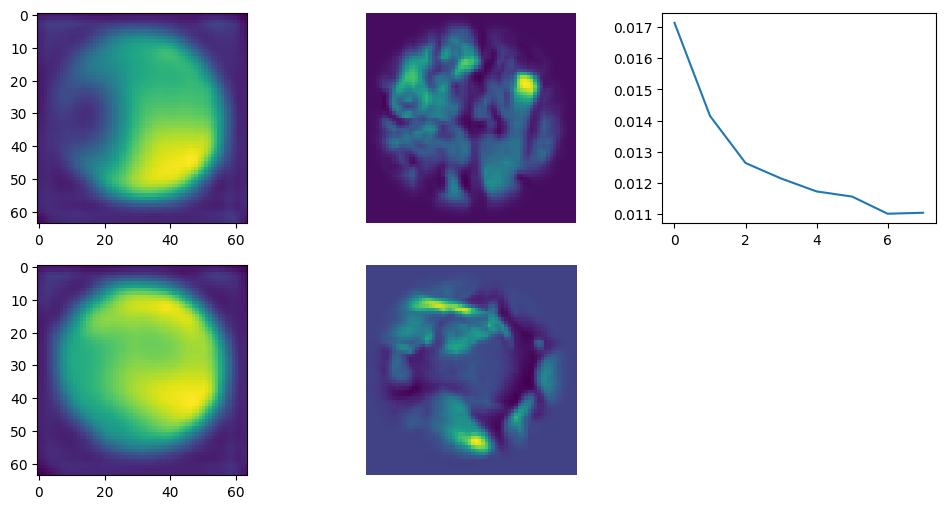

Finished epoch 7, latest loss 0.011046892032027245, time 37.12845206260681
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


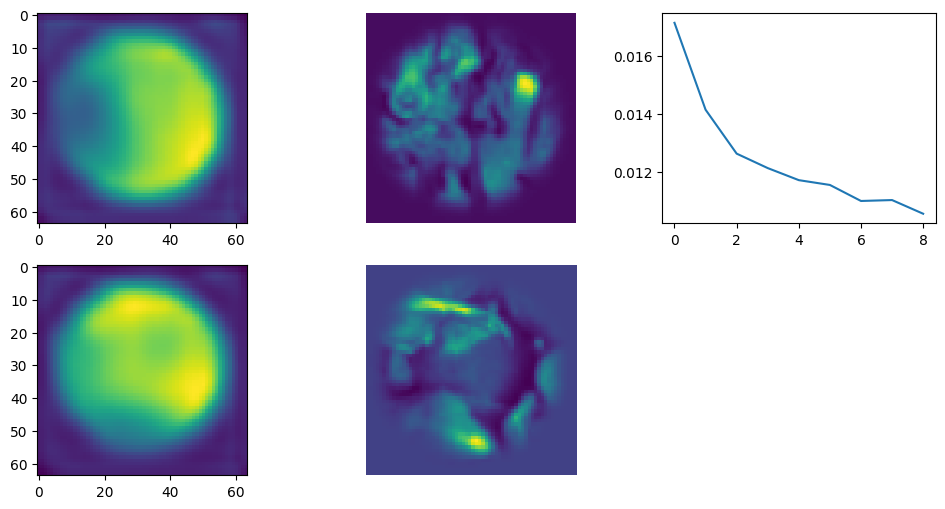

Finished epoch 8, latest loss 0.010577152483165264, time 36.77828574180603
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


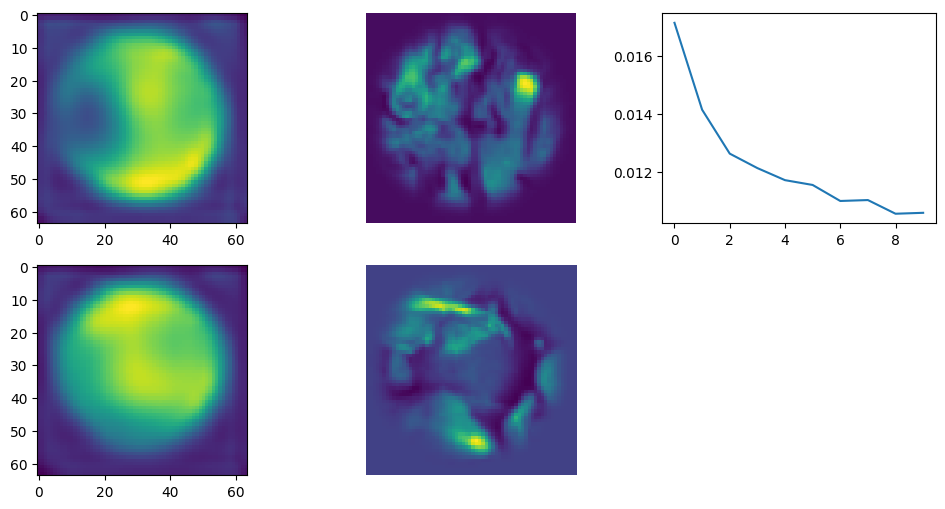

Finished epoch 9, latest loss 0.010608888231217861, time 38.78836250305176
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


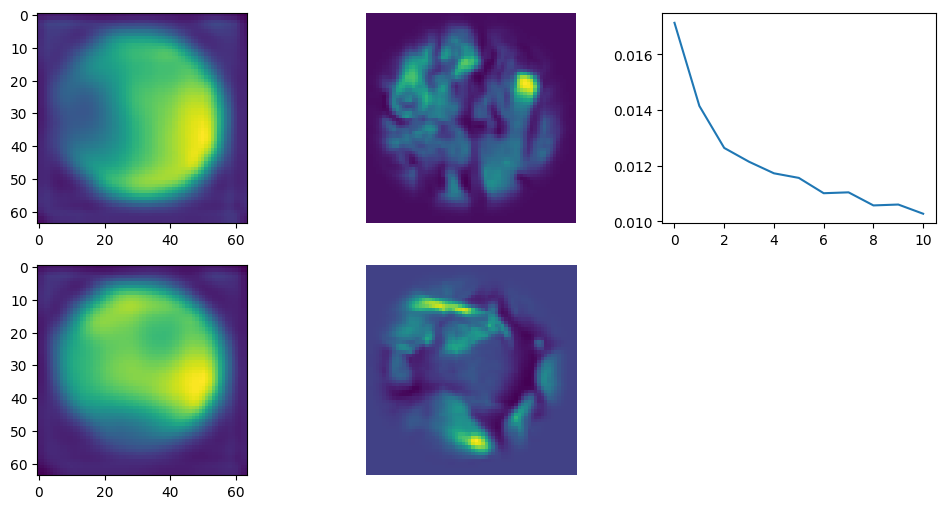

Finished epoch 10, latest loss 0.010278518311679363, time 36.57855677604675
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


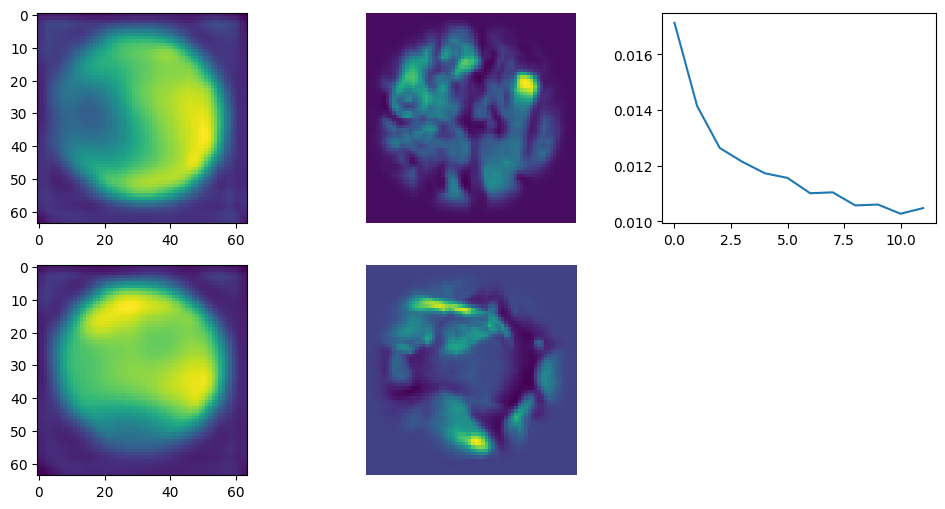

Finished epoch 11, latest loss 0.01048110518604517, time 36.52613306045532
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


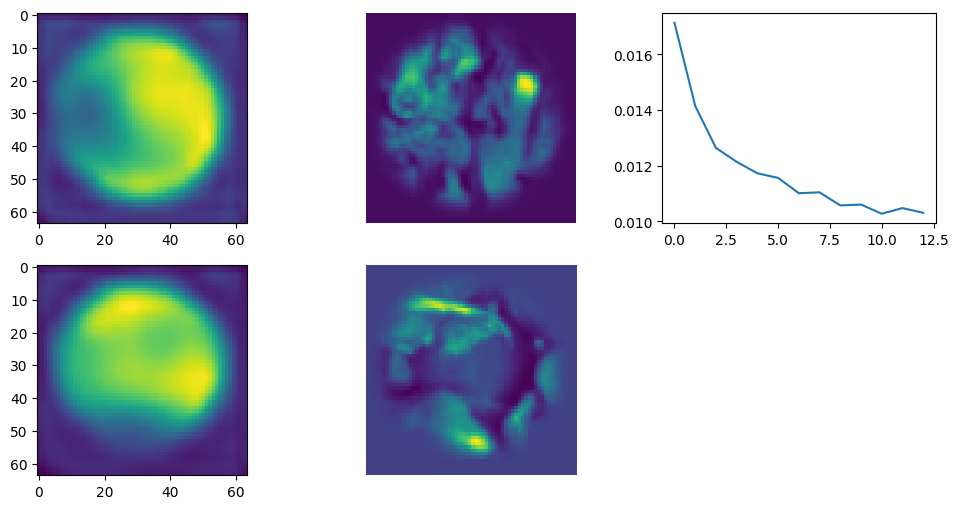

Finished epoch 12, latest loss 0.010313201695680618, time 37.64959692955017
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


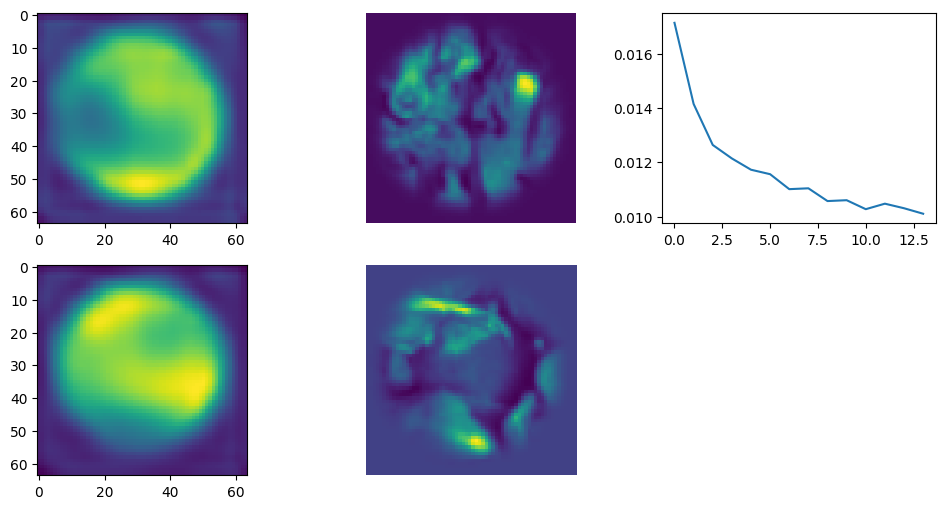

Finished epoch 13, latest loss 0.010111004114151001, time 38.175548791885376
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


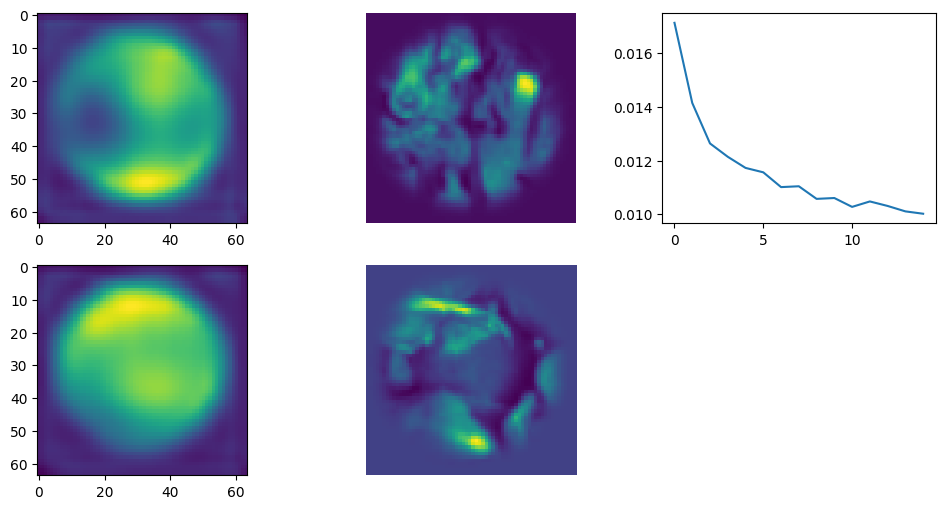

Finished epoch 14, latest loss 0.010023314505815506, time 36.670013427734375
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


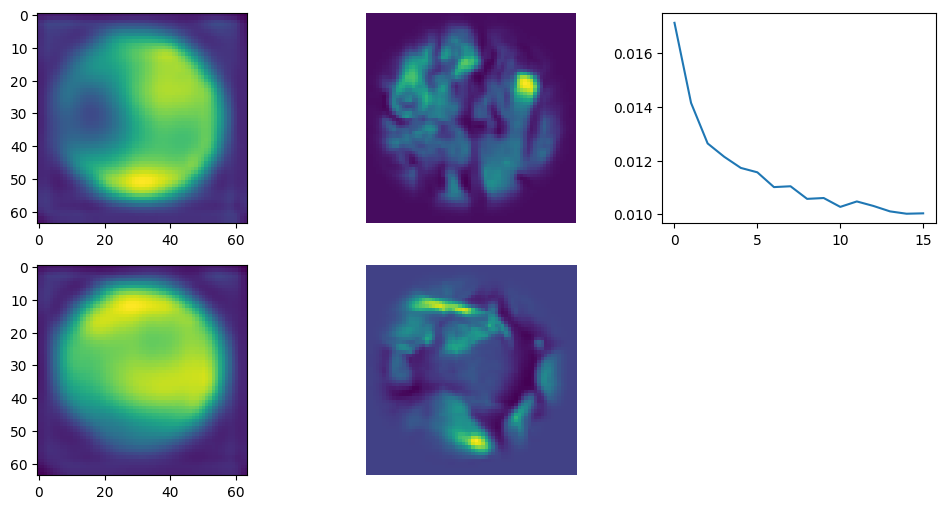

Finished epoch 15, latest loss 0.010038025677204132, time 36.75705432891846
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


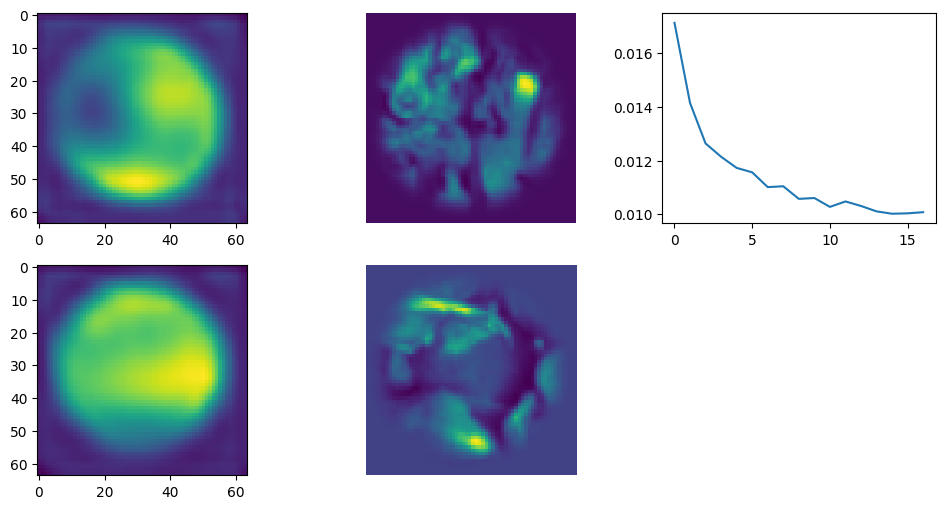

Finished epoch 16, latest loss 0.010081031359732151, time 39.001737117767334
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


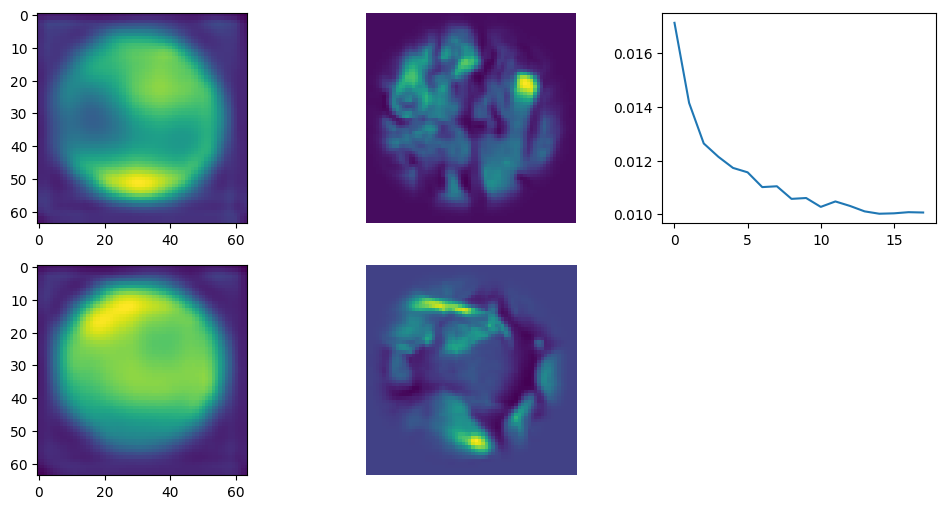

Finished epoch 17, latest loss 0.010068664327263832, time 37.03296732902527
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


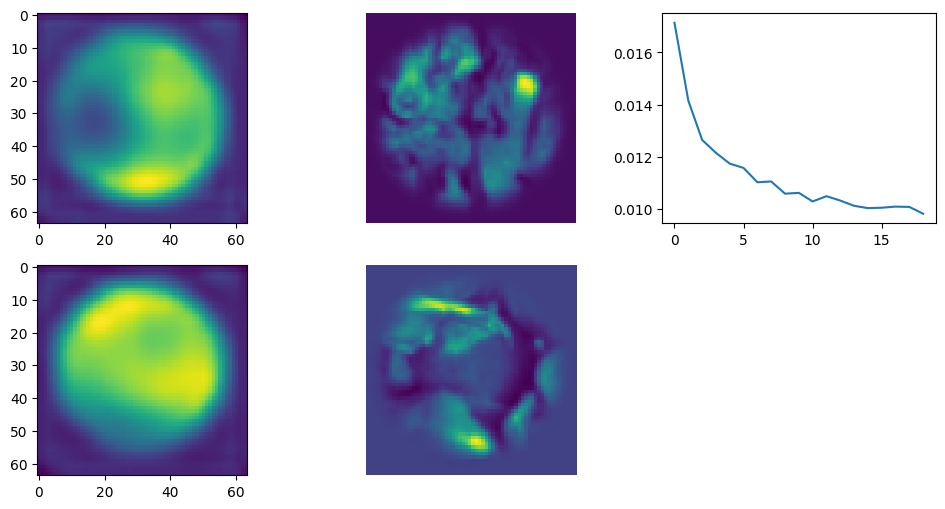

Finished epoch 18, latest loss 0.009807364083826542, time 36.244651556015015
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


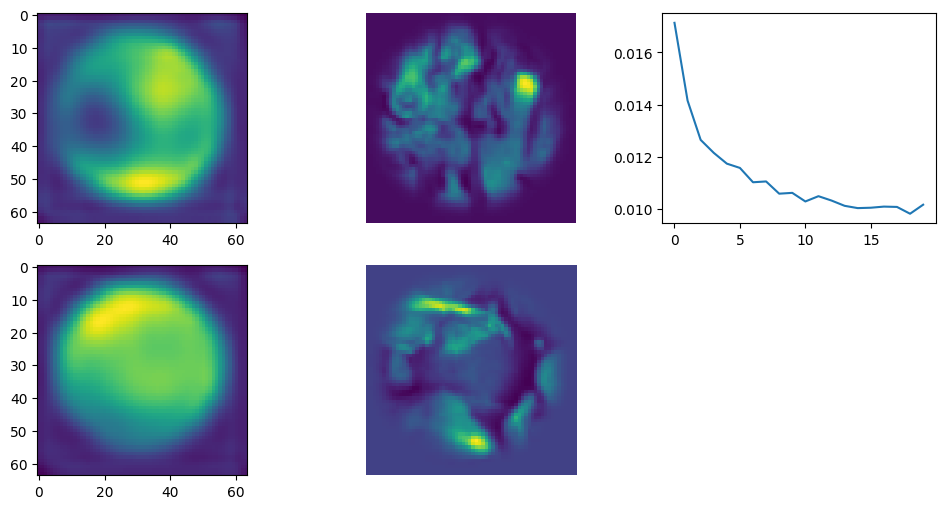

Finished epoch 19, latest loss 0.010153879411518574, time 37.764036655426025
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


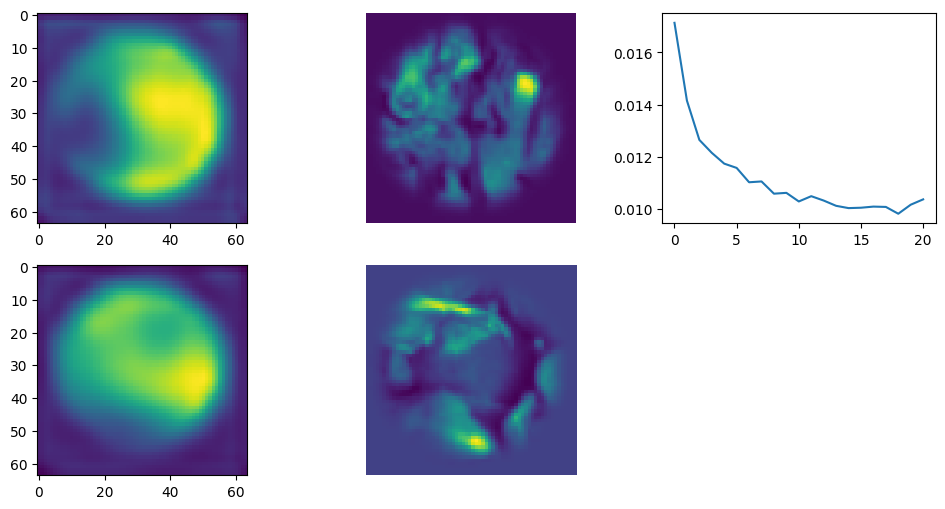

Finished epoch 20, latest loss 0.010358894243836403, time 37.04245352745056
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


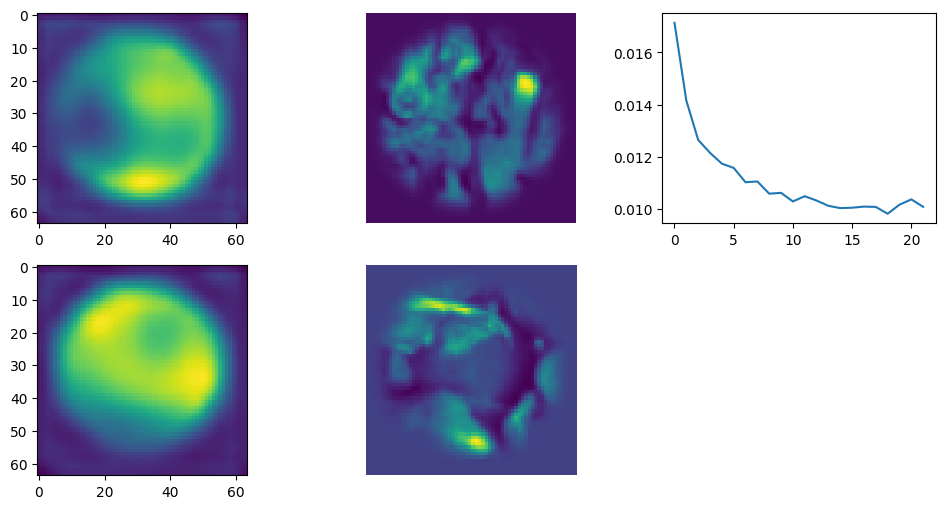

Finished epoch 21, latest loss 0.010072345845401287, time 36.47623586654663
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


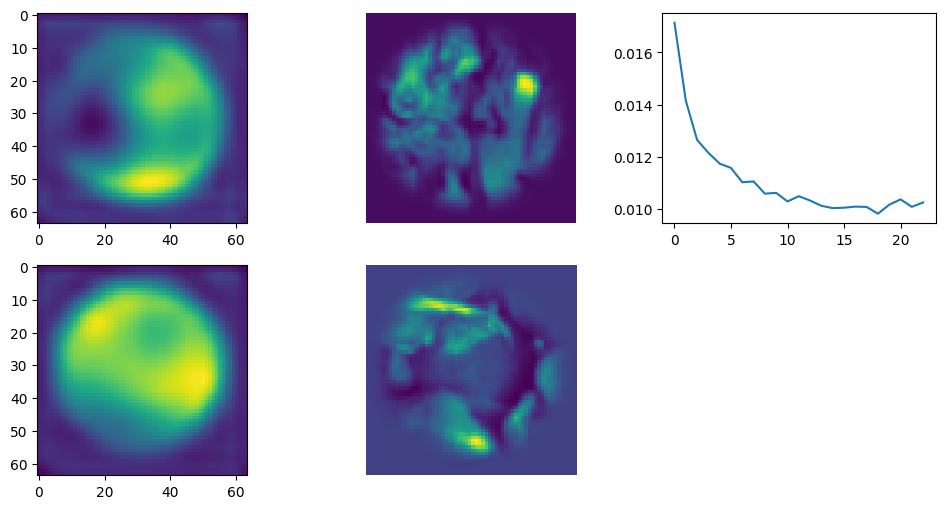

Finished epoch 22, latest loss 0.010239662602543831, time 36.18323111534119
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


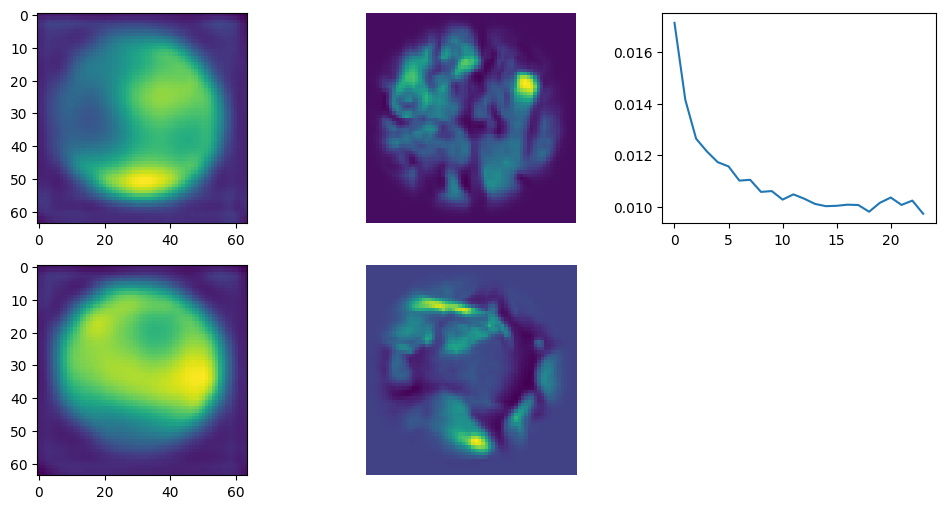

Finished epoch 23, latest loss 0.009730108082294464, time 39.02579474449158
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


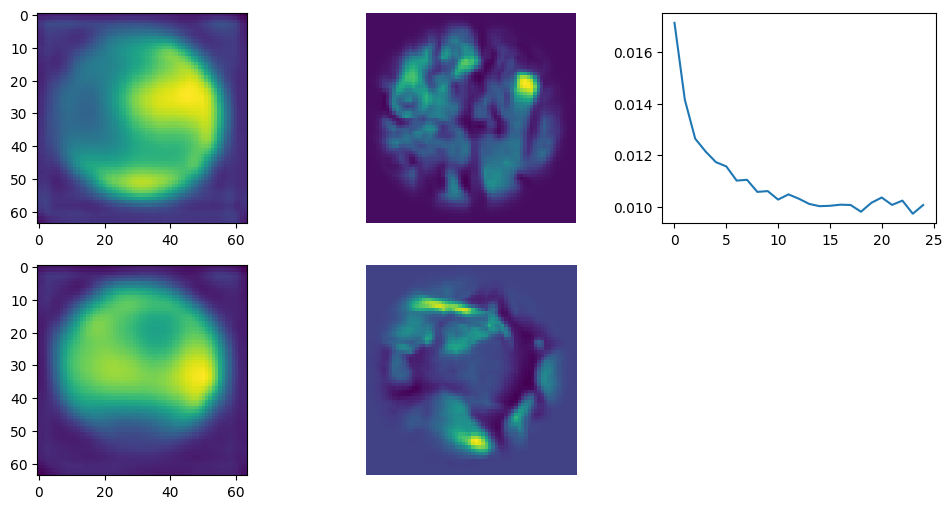

Finished epoch 24, latest loss 0.010067645460367203, time 36.256842374801636
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


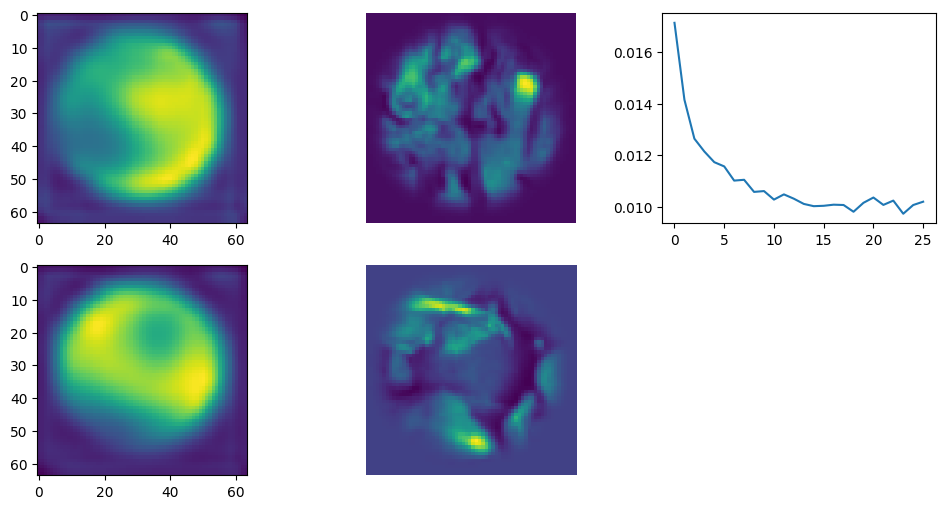

Finished epoch 25, latest loss 0.010197061114013195, time 36.128602266311646
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


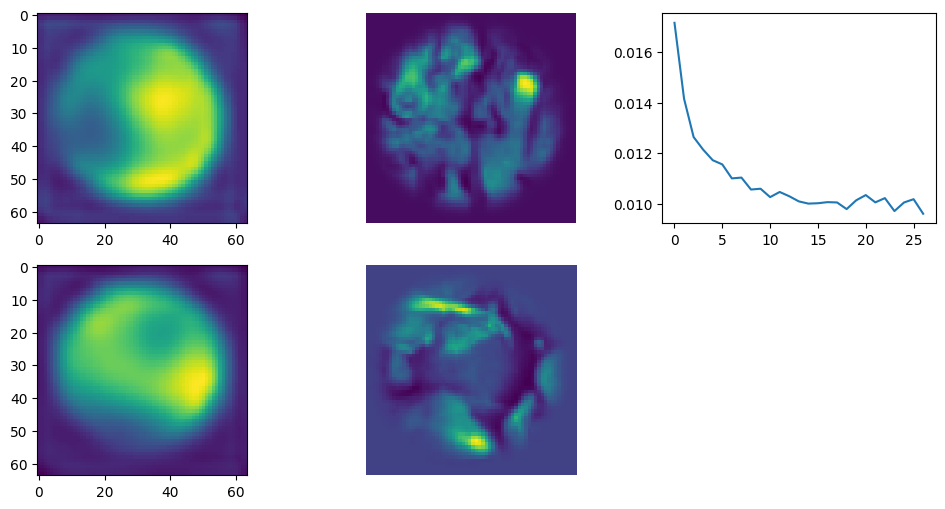

Finished epoch 26, latest loss 0.009624980390071869, time 37.89363932609558
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


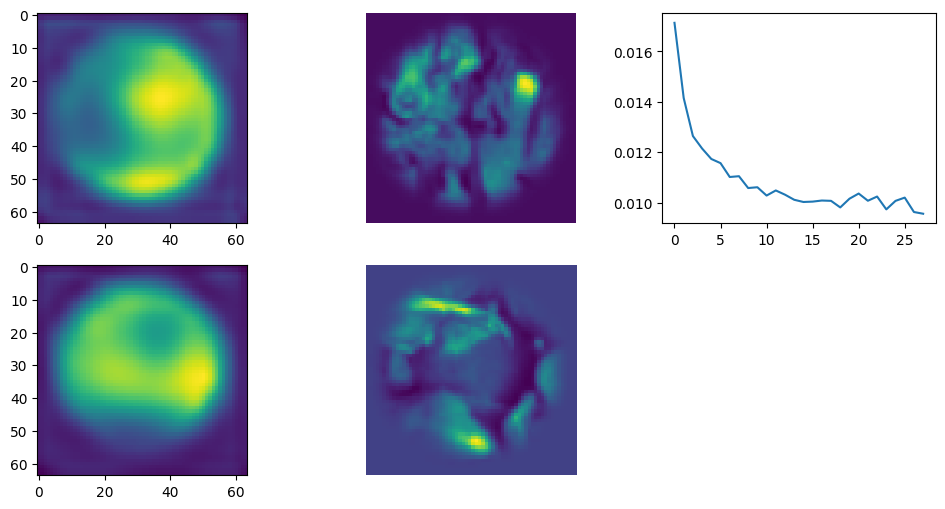

Finished epoch 27, latest loss 0.009556911885738373, time 37.83923864364624
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


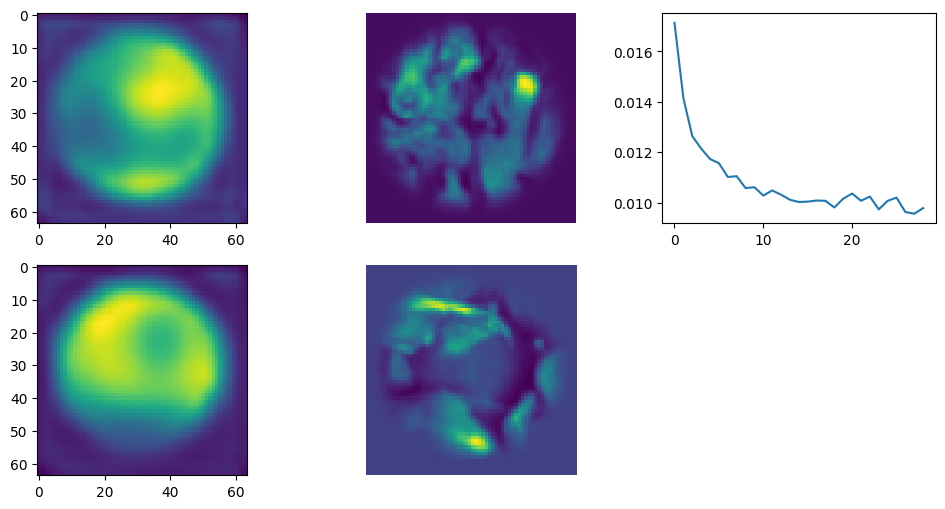

Finished epoch 28, latest loss 0.00978039763867855, time 36.43896198272705
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


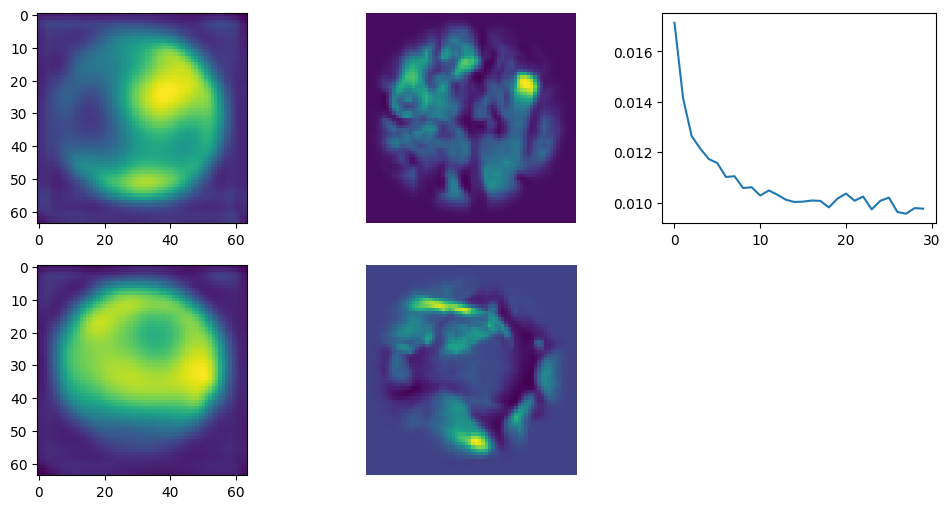

Finished epoch 29, latest loss 0.009758813306689262, time 36.674885511398315
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


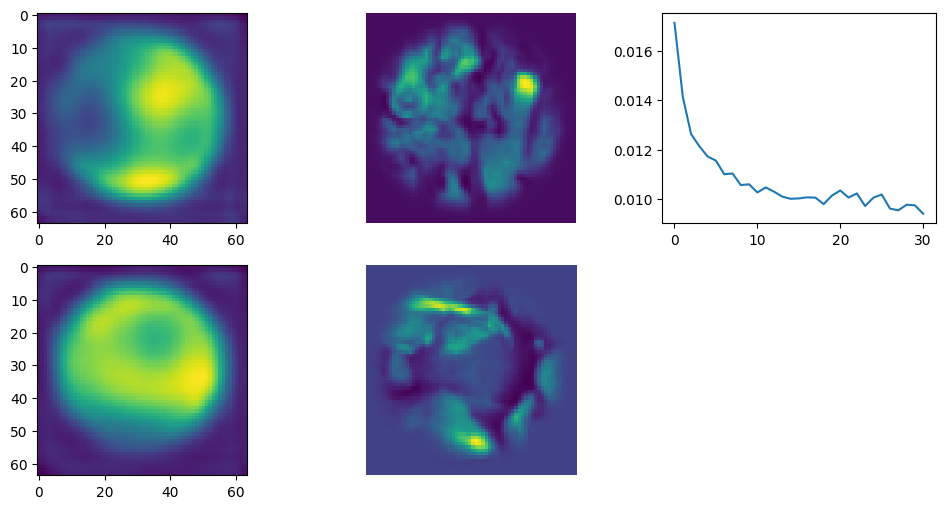

Finished epoch 30, latest loss 0.009418480098247528, time 39.114567279815674
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


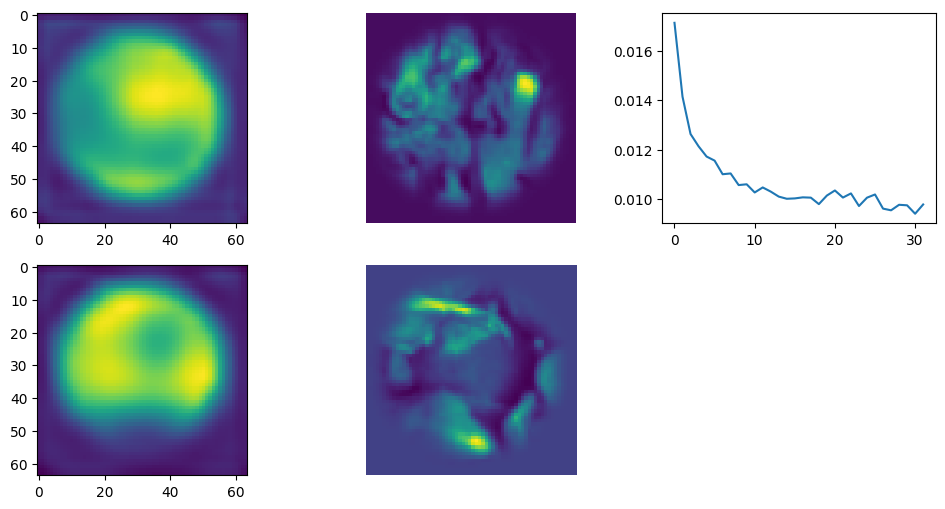

Finished epoch 31, latest loss 0.009792961180210114, time 36.45327615737915
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


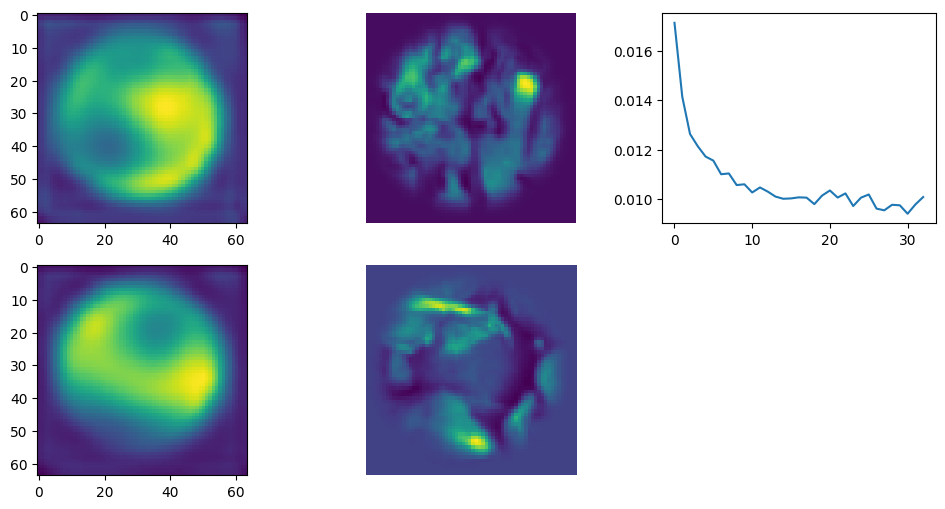

Finished epoch 32, latest loss 0.010092283599078655, time 36.8324716091156
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


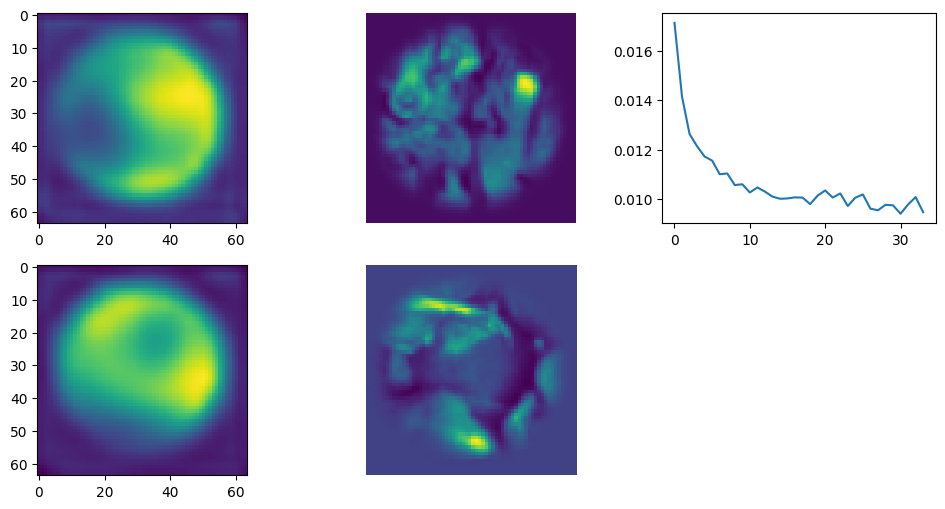

Finished epoch 33, latest loss 0.009482280351221561, time 38.21802496910095
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


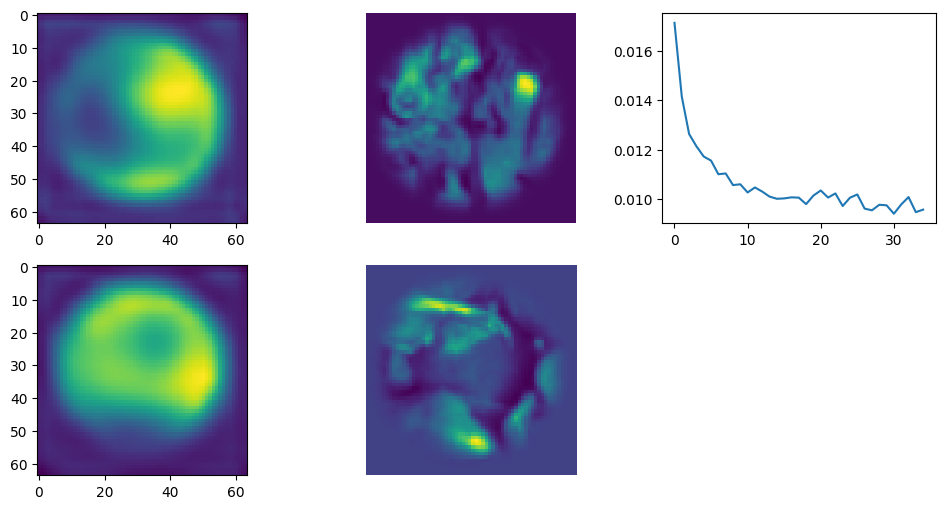

Finished epoch 34, latest loss 0.009584501385688782, time 37.45406985282898
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


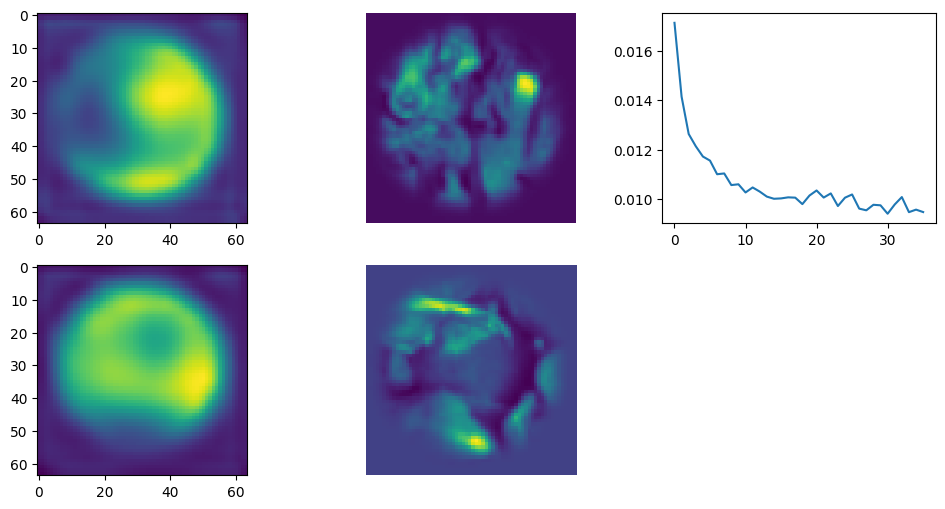

Finished epoch 35, latest loss 0.009485897608101368, time 36.334426164627075
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


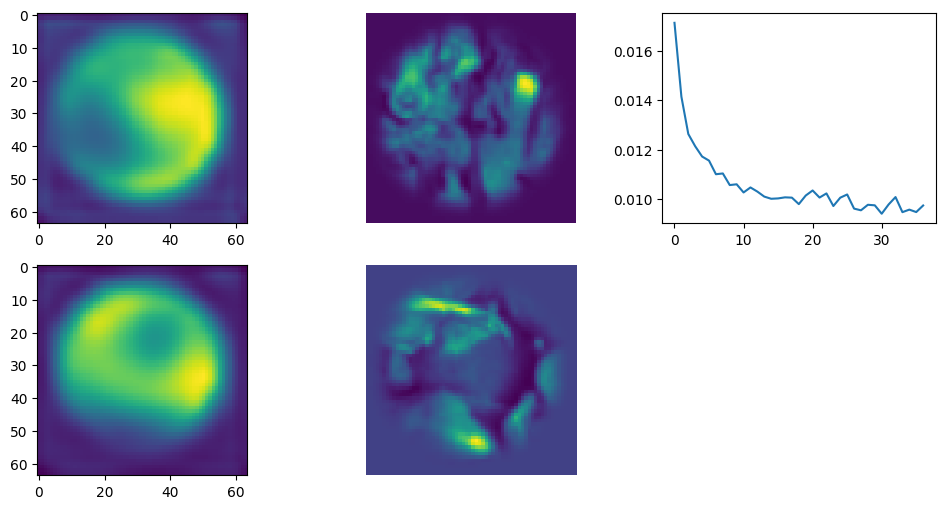

Finished epoch 36, latest loss 0.009752103127539158, time 37.05208230018616
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


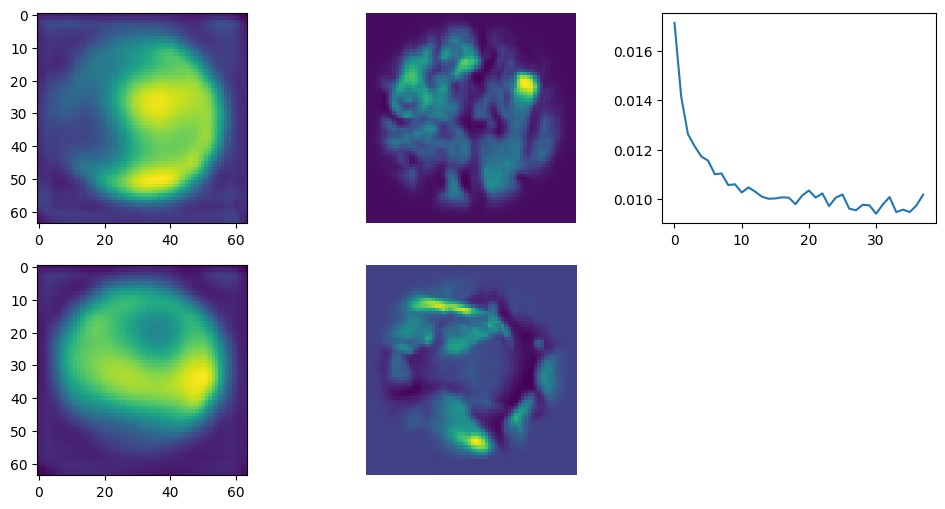

Finished epoch 37, latest loss 0.010190578177571297, time 38.83358454704285
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


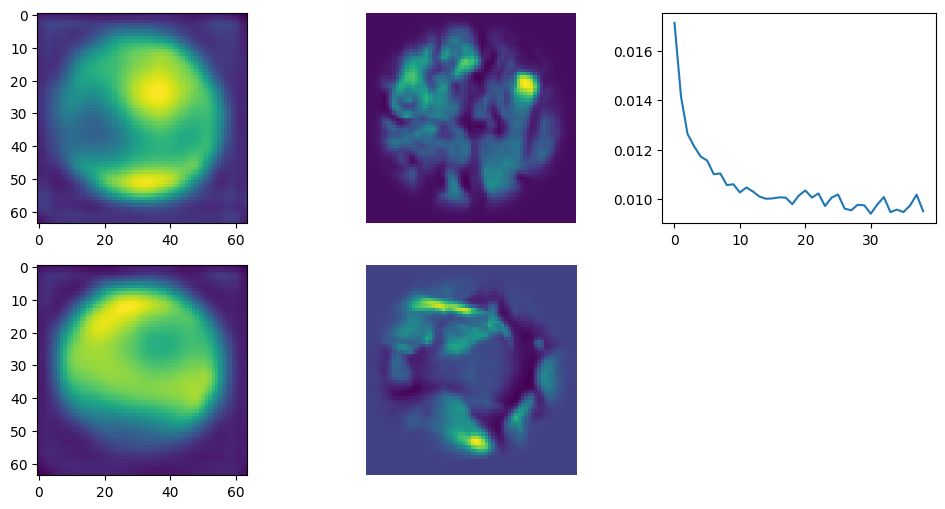

Finished epoch 38, latest loss 0.009518359787762165, time 37.05017137527466
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


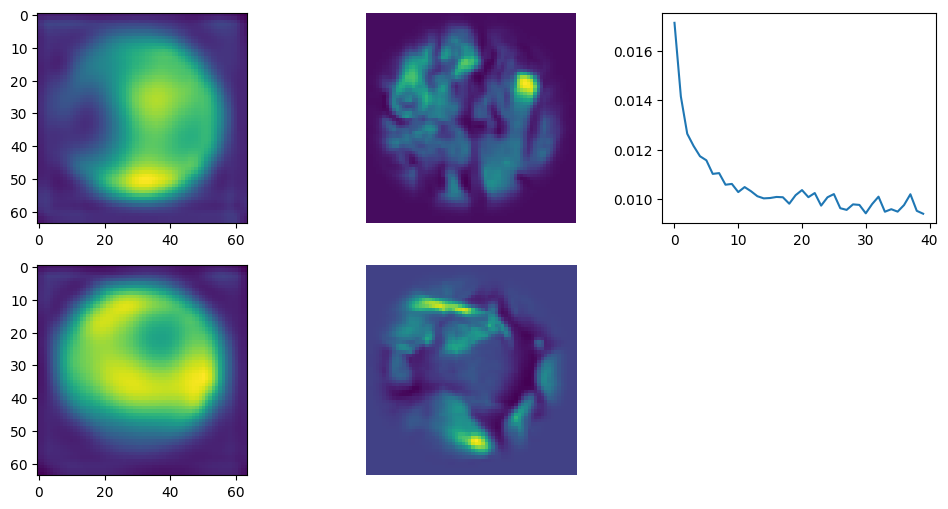

Finished epoch 39, latest loss 0.009401049464941025, time 37.13473868370056
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


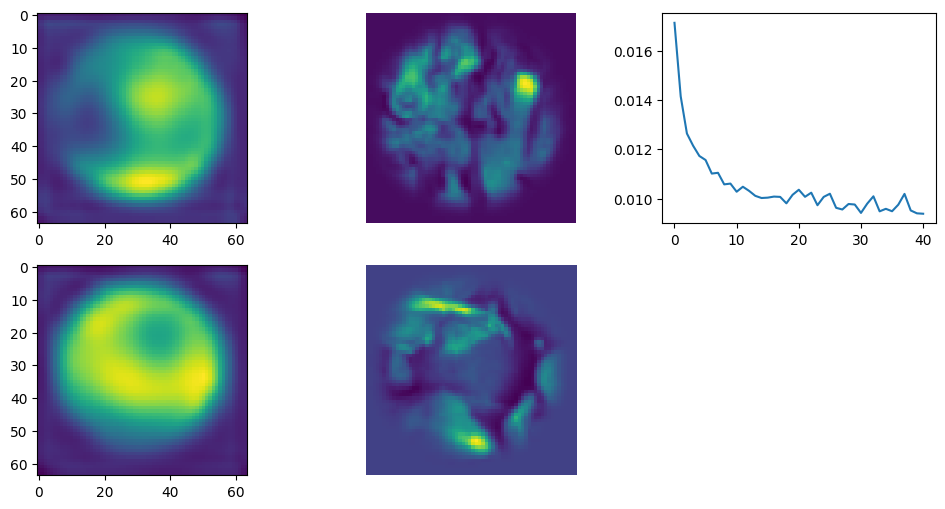

Finished epoch 40, latest loss 0.009384918957948685, time 40.36875581741333
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


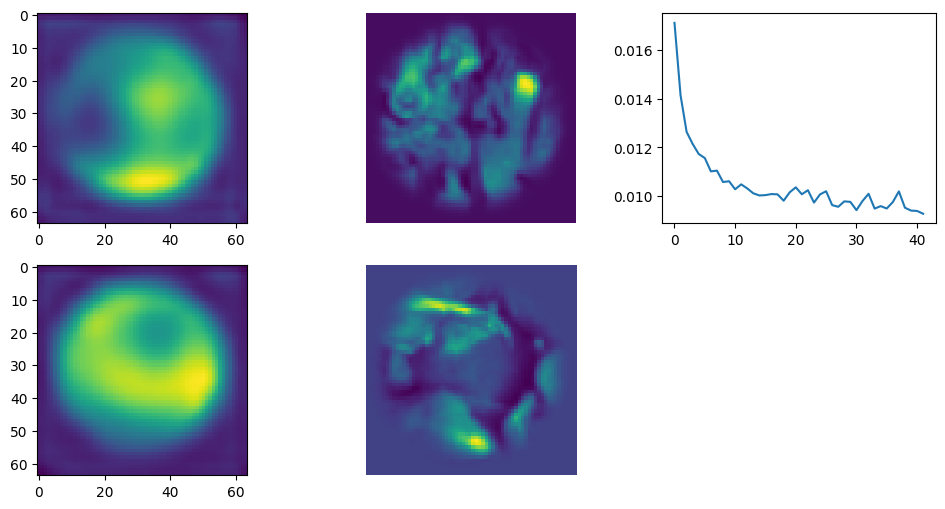

Finished epoch 41, latest loss 0.009270675480365753, time 37.44255232810974
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


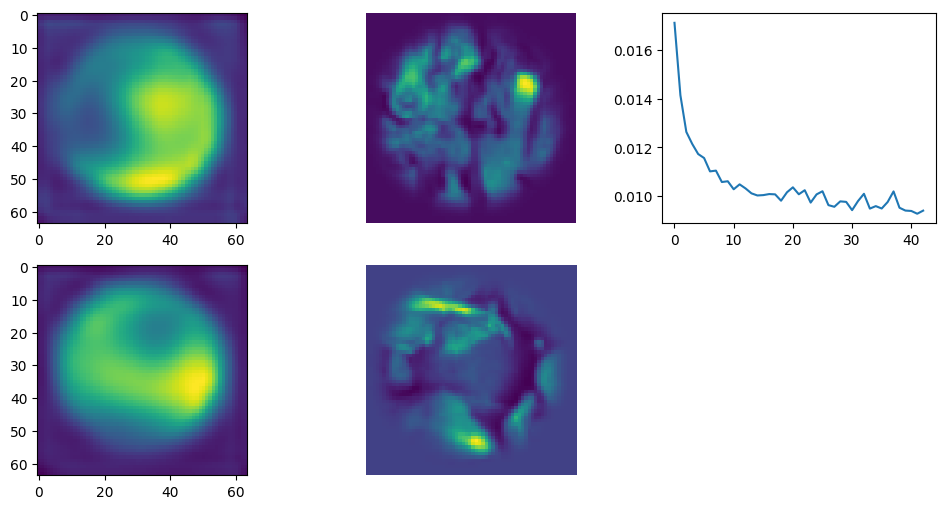

Finished epoch 42, latest loss 0.009398672729730606, time 37.67072868347168
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


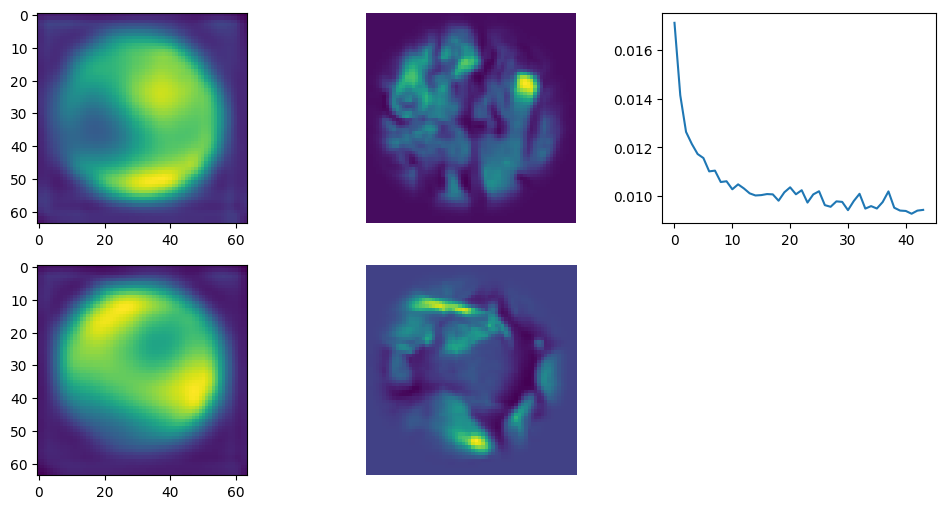

Finished epoch 43, latest loss 0.009429310448467731, time 39.3106803894043
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


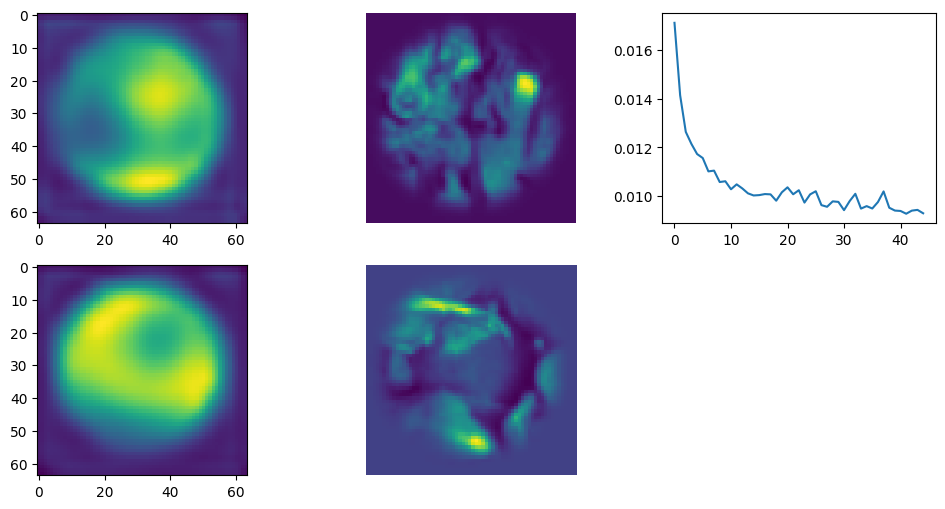

Finished epoch 44, latest loss 0.009289233945310116, time 36.98372220993042
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


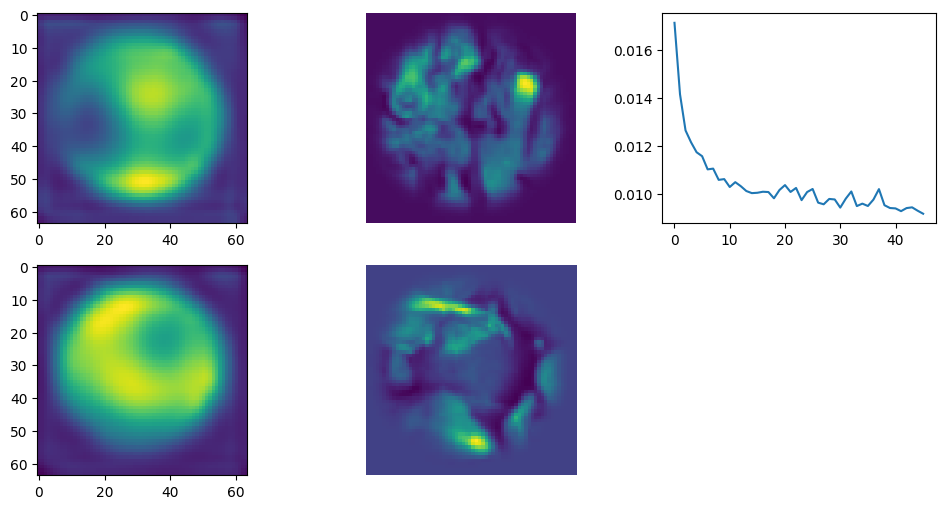

Finished epoch 45, latest loss 0.009162488393485546, time 37.2385573387146
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


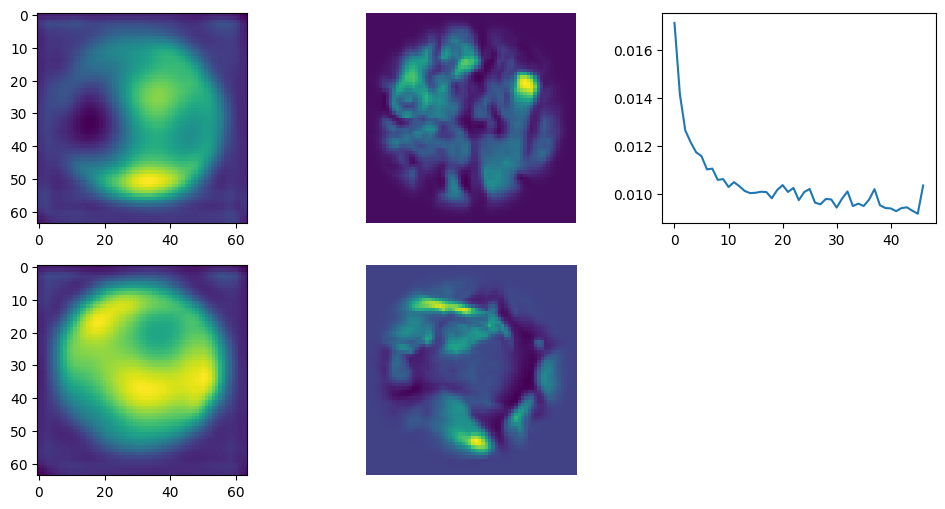

Finished epoch 46, latest loss 0.010343411937355995, time 39.59439206123352
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


KeyboardInterrupt: ignored

In [ ]:
loss_values = []
for epoch in range(n_epochs):
    start = time.time()
    for i in range(0, len(X), batch_size):
      if i%1000 ==0:
        print(i)
      Xbatch = torch.from_numpy(X[i:i + batch_size]).float()  # Convert to PyTorch tensor
      Ybatch = torch.from_numpy(Y[i:i + batch_size]).float()

      Ypred = model3(Xbatch).squeeze(1)

      #Image is upscaled to 64x64 for the loss function. In retrospect, the prediction should be have been downscaled to better align with other neural network's loss functions
      Ybatch_upscaled = F.interpolate(Ybatch.view(-1, 50, 50).unsqueeze(1), size=(64,64), mode='bilinear', align_corners=False).squeeze(1)


      #loss function is based on images

      loss = loss_fn(Ypred, Ybatch_upscaled)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    loss_values.append(loss.item())
    with torch.no_grad():
      if epoch %1 == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(model3(torch.from_numpy(X[0:1]).float()).detach().cpu().numpy()[0][0])
        plt.subplot(2, 3, 2)
        plt.imshow(Ybatch_upscaled[0])
        plt.axis('off')
        plt.subplot(2, 3, 3)
        plt.plot(loss_values)
        plt.subplot(2, 3, 4)
        plt.imshow(model3(torch.from_numpy(X[1:2]).float()).detach().cpu().numpy()[0][0])
        plt.subplot(2, 3, 5)
        plt.imshow(Ybatch_upscaled[1])
        plt.axis('off')
        plt.show()
    print(f'Finished epoch {epoch}, latest loss {loss}, time {time.time() - start}')


In [ ]:
torch.save(model3.state_dict(), 'models/M3_300epo_1000batch_25ktrain.pth')
test = model3(torch.from_numpy(val_predict_rsp[25000:25001]).float()).detach().cpu().numpy()[0][0]
# Display the 64x64 grayscale image
plt.imshow(test)

plt.show()

#Neural Network Model 4 - Convolutional Neural Network with Perceptual Loss

##*Define Model Architecture

In [ ]:
#same as model 3
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Linear layers to map input (302) to 2048
        self.fc1 = nn.Linear(302, 1024)
        self.fc2 = nn.Linear(1024, 2048)

        # Convolutional layers
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2= nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv4 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.upsample4 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv5 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.upsample5 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv6 = nn.Conv2d(4, 2, kernel_size=3, stride=1, padding=1)
        self.upsample6 = nn.Upsample(scale_factor=2, mode='bicubic')

        self.conv7 = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1)
        self.upsample7 = nn.Upsample(scale_factor=2, mode='bicubic')

    def forward(self, x):
        # Linear layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Reshape to (1, 4, 4, 128)
        x = x.view(x.shape[0], 128, 4, 4) # in future, can try parallel convolution, where we change this 128x4x4 and convolve it in 2 separate paths. then combine later (like in conv6).
        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.upsample4(x)
        x = torch.relu(self.conv5(x))
        x = self.upsample5(x)
        x = torch.relu(self.conv6(x))
        x = self.upsample6(x)
        x = torch.relu(self.conv7(x))
        x = self.upsample7(x)
        return x

# Create an instance of the model
model4 = CustomCNN()

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# Training parameters
n_epochs = 10
batch_size = 100




##*Load if not Training

In [ ]:
model4.load_state_dict(torch.load('models/M4_30epo_100batch_25ktrain.pth', map_location = device))  #run this if on cpu

<All keys matched successfully>

##Training Loop

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


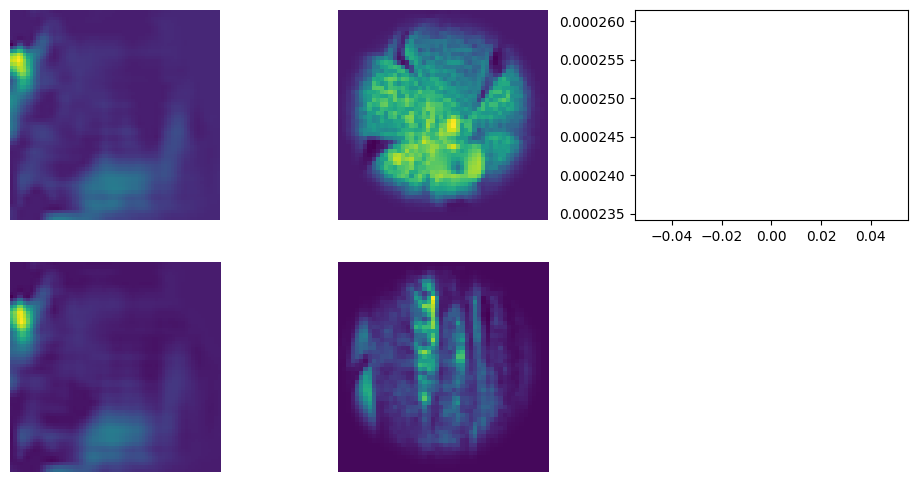

Finished epoch 0, latest loss 0.00024782633408904076, time 188.43491625785828
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


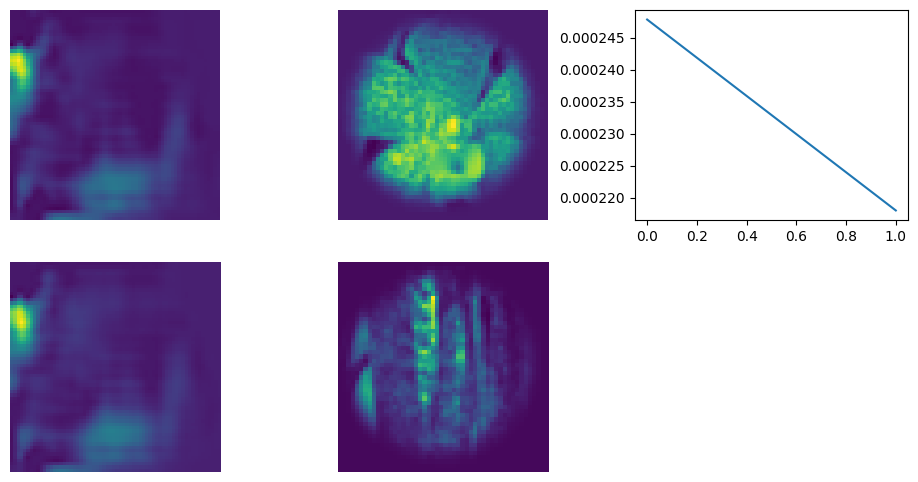

Finished epoch 1, latest loss 0.00021801638649776578, time 188.14490151405334
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


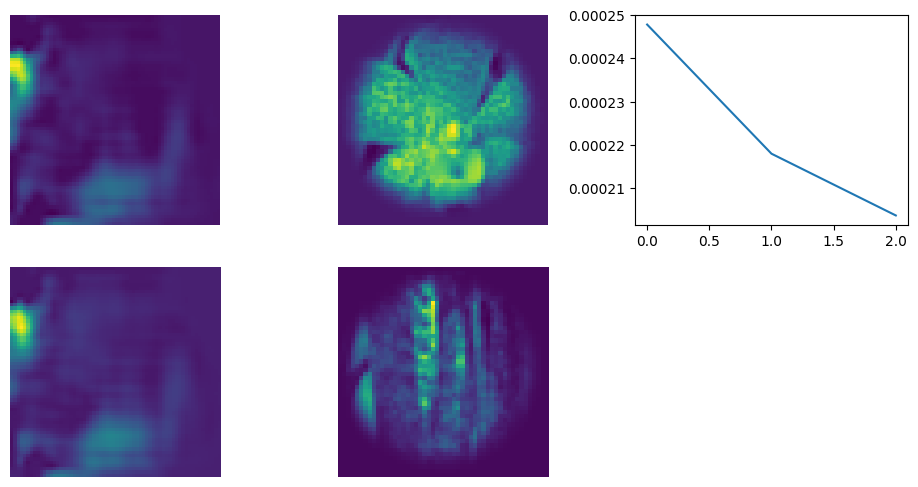

Finished epoch 2, latest loss 0.00020376092288643122, time 187.80271077156067
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


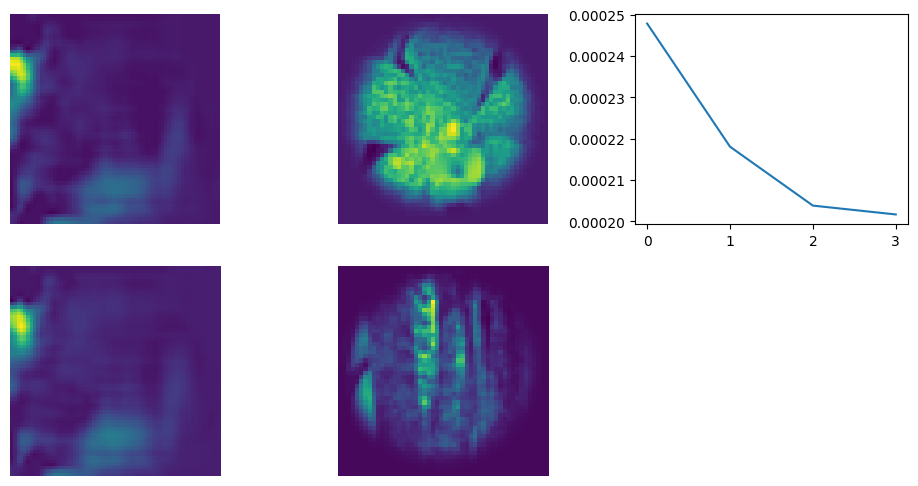

Finished epoch 3, latest loss 0.00020161956490483135, time 187.7401921749115
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


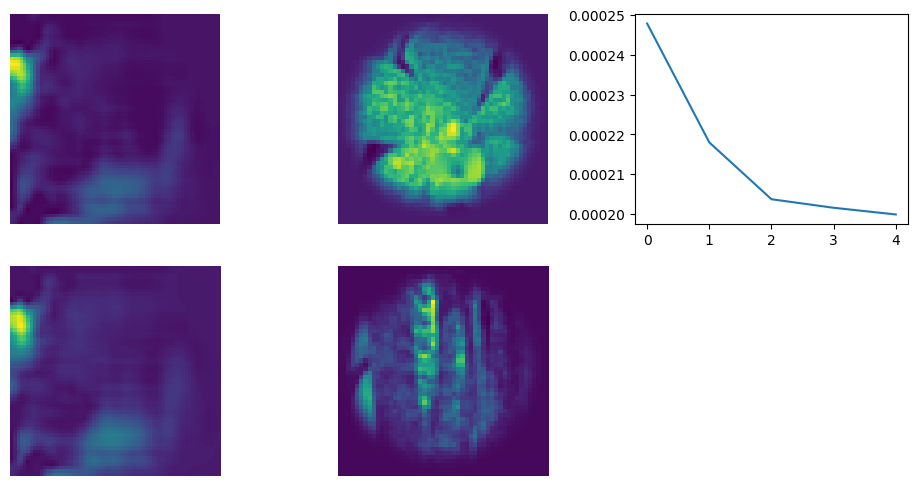

Finished epoch 4, latest loss 0.0001999446249101311, time 187.72593069076538
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


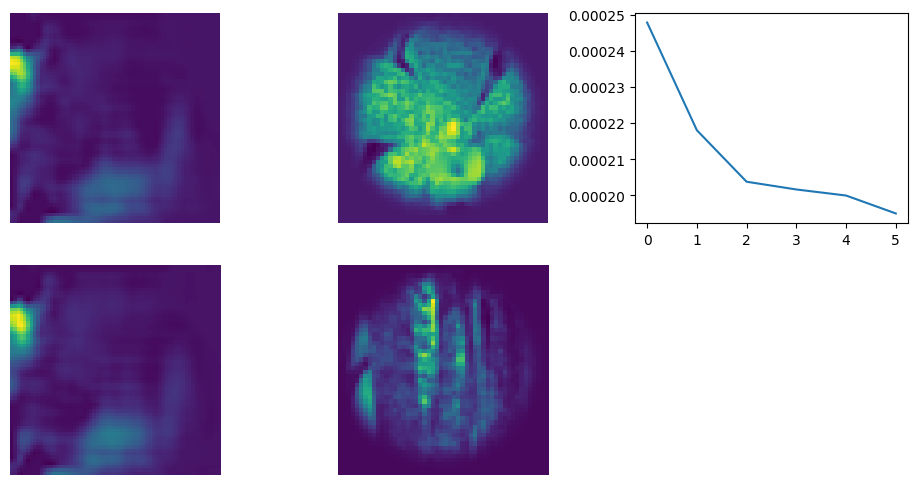

Finished epoch 5, latest loss 0.00019498090841807425, time 187.7838613986969
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


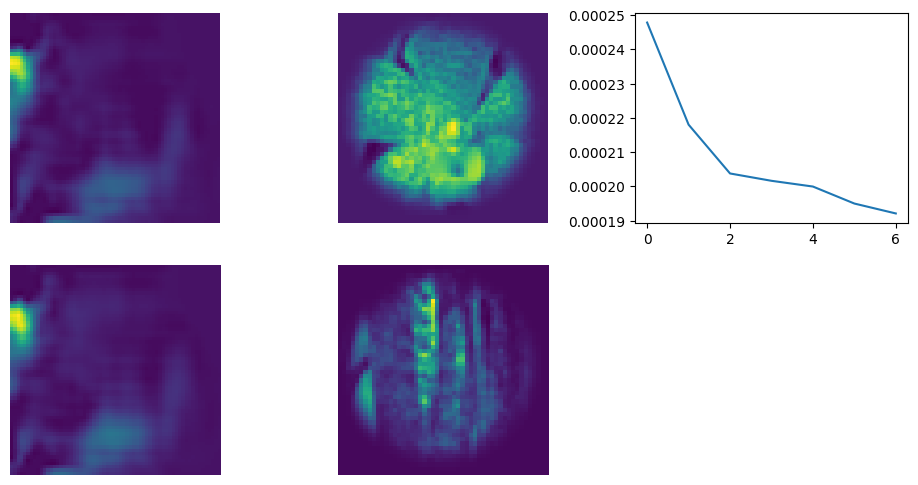

Finished epoch 6, latest loss 0.0001920864888234064, time 187.61322617530823
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


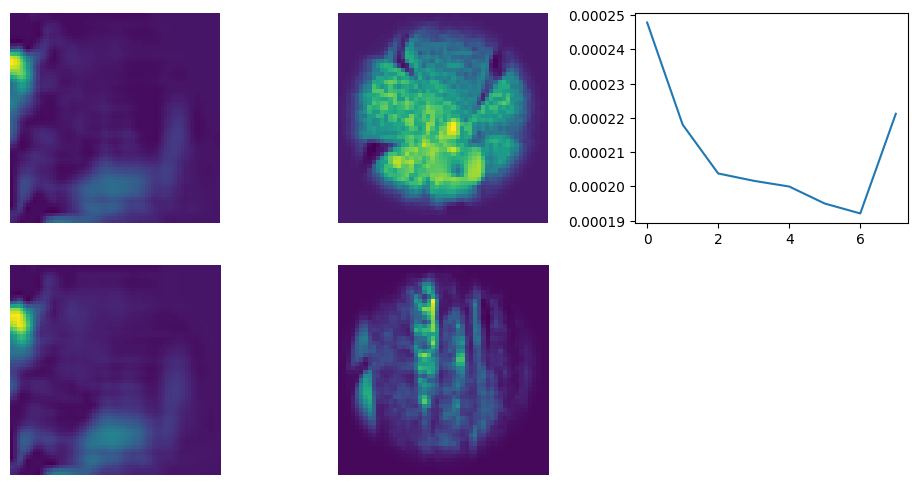

Finished epoch 7, latest loss 0.00022118094784673303, time 187.80098342895508
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


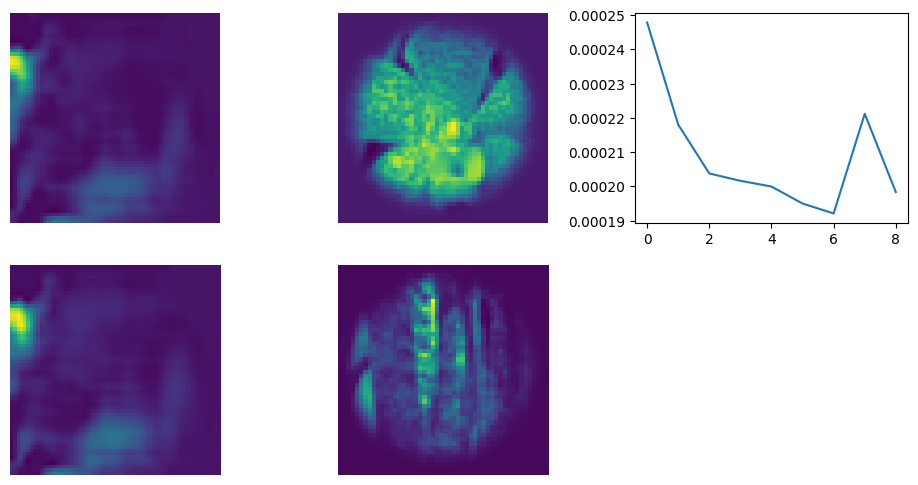

Finished epoch 8, latest loss 0.00019834464183077216, time 187.60930228233337
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


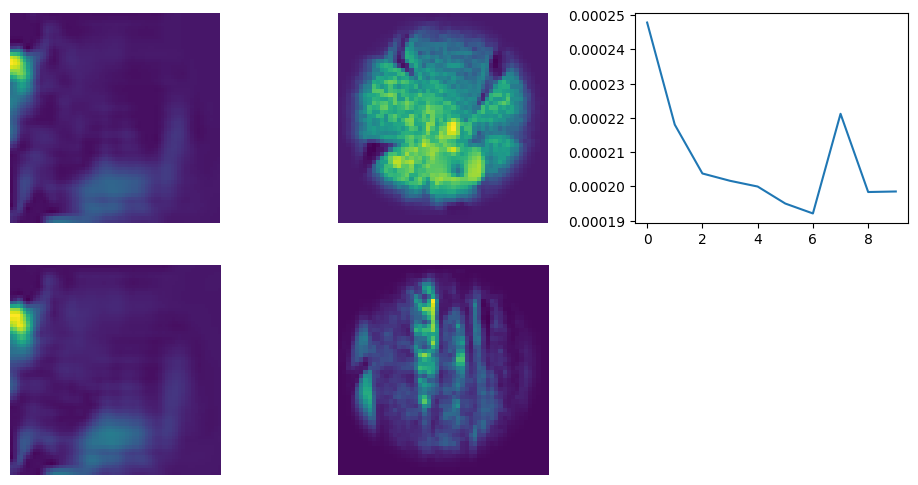

Finished epoch 9, latest loss 0.0001985013805096969, time 187.68289494514465


In [ ]:
loss_values = []
for epoch in range(n_epochs):
    start = time.time()
    for i in range(0, len(X), batch_size):
      if i%1000 ==0:
        print(i)
      Xbatch = torch.from_numpy(X[i:i + batch_size]).float().cuda()  # Convert to PyTorch tensor
      Ybatch = torch.from_numpy(Y[i:i + batch_size]).float()

      #Images is downscaled to 50x50 to fit into the net
      Ypred = F.interpolate(model4(Xbatch), size=(50, 50), mode='bicubic', align_corners=False).squeeze(1)
      pred_response = net(Ypred.reshape(batch_size,1,50,50).cuda())

      #Loss Function is based on Response
      loss = loss_fn(pred_response, Xbatch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_values.append(loss.item())
    with torch.no_grad():
      if epoch %1 == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(model4(torch.from_numpy(X[0:1]).float().cuda()).squeeze(1).detach().cpu().numpy()[0])
        plt.axis('off')
        plt.subplot(2, 3, 2)
        plt.imshow(Ybatch[0].reshape(50,50))
        plt.axis('off')
        plt.subplot(2, 3, 3)
        plt.plot(loss_values)
        plt.subplot(2, 3, 4)
        plt.imshow(model4(torch.from_numpy(X[1:2]).float().cuda()).squeeze(1).detach().cpu().numpy()[0])
        plt.axis('off')
        plt.subplot(2, 3, 5)
        plt.imshow(Ybatch[1].reshape(50,50))
        plt.axis('off')
        plt.show()
    print(f'Finished epoch {epoch}, latest loss {loss}, time {time.time() - start}')


##Save model Parameters

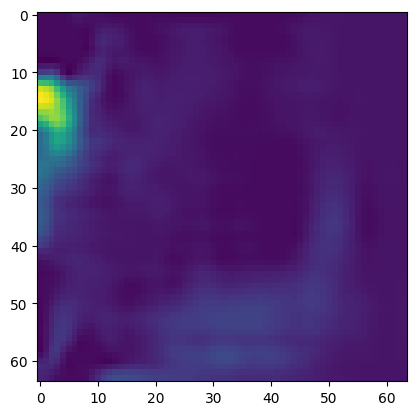

In [ ]:
torch.save(model4.state_dict(), 'models/M4_40epo_100batch_25ktrain.pth')


# Display the 64x64 grayscale image
plt.imshow(model4(torch.from_numpy(val_predict_rsp[25001:25002]).float().cuda()).detach().cpu().numpy()[0][0], cmap = 'gray')

#*Data Analysis for All/Each Model


##Important Functions

In [ ]:
def origin_pic(cell_num):
  return real_rsp_pair_pics[cell_num ].reshape(50, 50)

def model1_pic(cell_num):
  return model1(torch.from_numpy(val_predict_rsp[cell_num])).detach().numpy().reshape(50, 50)

def model2_pic(cell_num):
  return model2(torch.from_numpy(val_predict_rsp[cell_num])).detach().cpu().numpy().reshape(50, 50)

def model3_pic(cell_num):
  return F.interpolate(model3(torch.from_numpy(val_predict_rsp[cell_num:cell_num+1]).float().to(device)), size=(50,50), mode='bicubic', align_corners=False).detach().cpu().numpy()[0][0]

def model4_pic(cell_num):
  return F.interpolate(model4(torch.from_numpy(val_predict_rsp[cell_num:cell_num+1]).float().to(device)), size=(50,50), mode='bicubic', align_corners=False).detach().cpu().numpy()[0][0]

def origin_neu(cell_num):
  return np.array(net(torch.from_numpy(real_rsp_pair_pics[cell_num].reshape(1,1,50,50)).float().to(device)).cpu().flatten().detach())

def model1_neu(cell_num):
  return np.array(net(torch.from_numpy(model1_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach())

def model2_neu(cell_num):
  return np.array(net(torch.from_numpy(model2_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach())

def model3_neu(cell_num):
  return np.array(net(torch.from_numpy(model3_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach())

def model4_neu(cell_num):
  return np.array(net(torch.from_numpy(model4_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach())

##Image Generation for All 4 + Neuron Responses for All 4

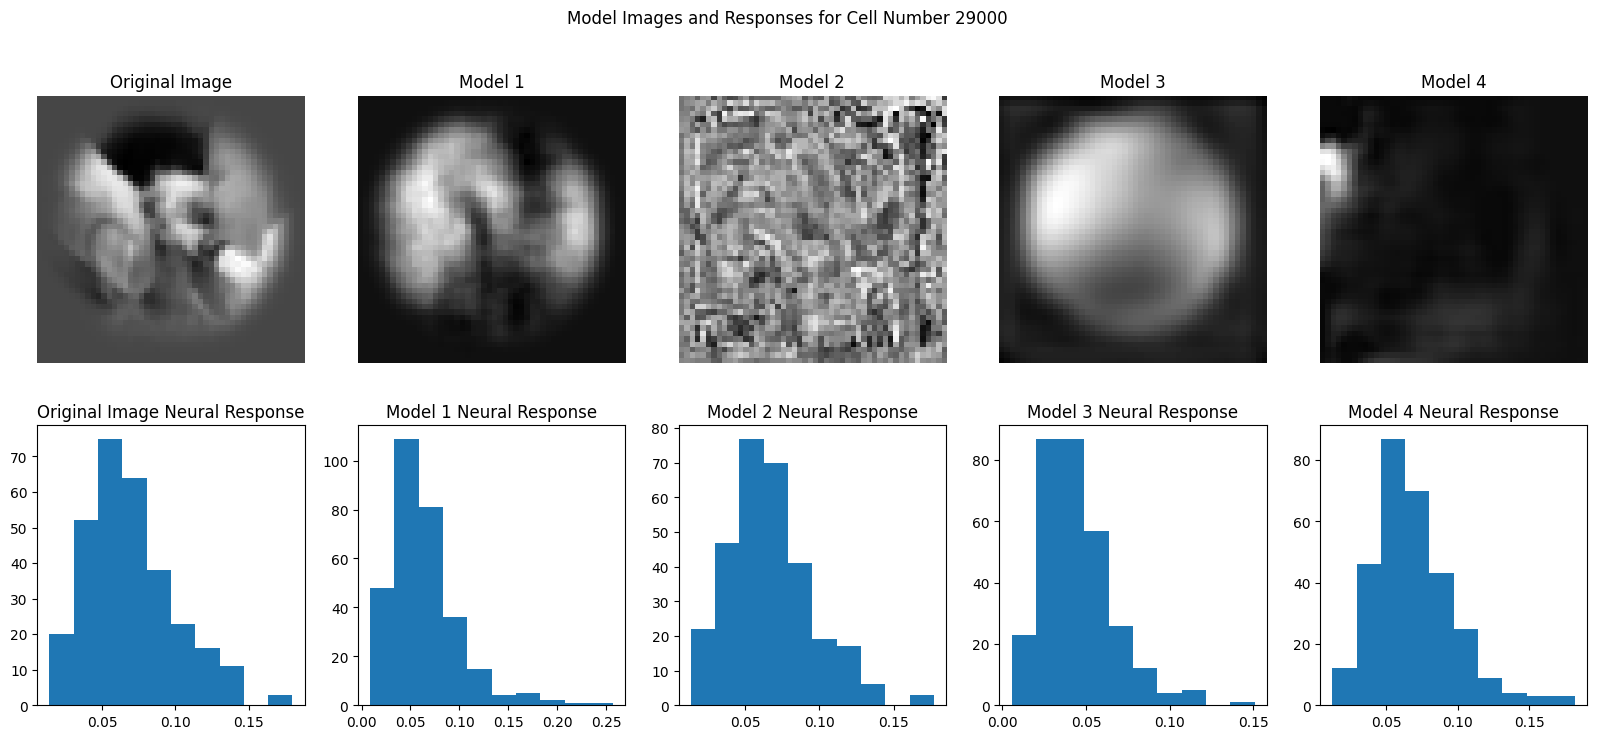

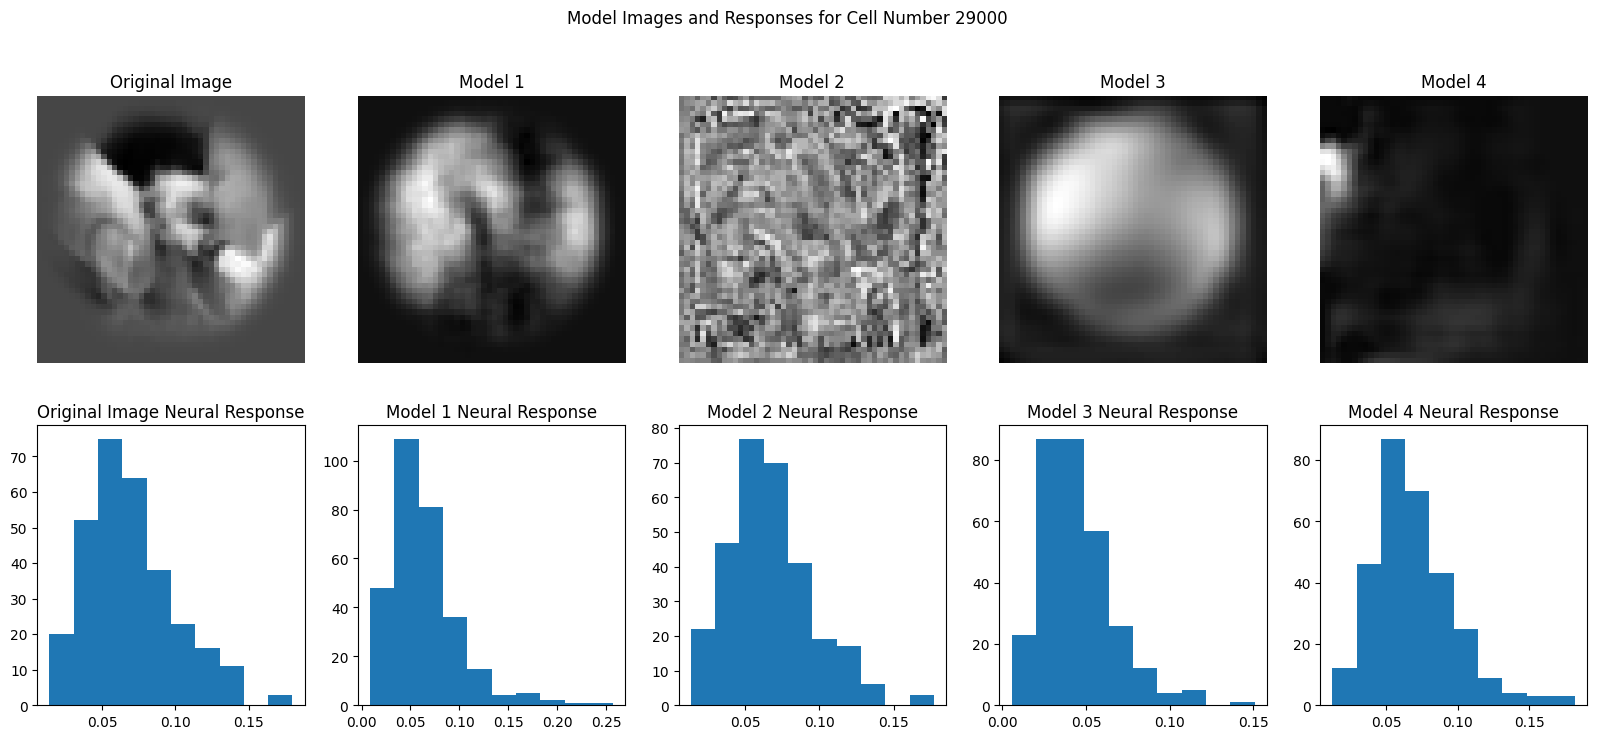

In [ ]:
def images_plot(cell_num):
  plt.subplots(2, 5, figsize = (20,8))

  cell_num = 29000
  plt.suptitle(f"Model Images and Responses for Cell Number {cell_num}")

  plt.subplot(2,5, 1)
  plt.imshow(real_rsp_pair_pics[cell_num ].reshape(50, 50), cmap = 'gray')
  plt.title(f"Original Image")
  plt.axis('off')

  plt.subplot(2,5, 2)
  plt.imshow(model1_pic(cell_num), cmap = 'gray')
  plt.title(f"Model 1")

  plt.axis('off')

  plt.subplot(2,5, 3)
  plt.imshow(model2_pic(cell_num), cmap = 'gray')
  plt.title(f"Model 2")
  plt.axis('off')

  plt.subplot(2,5, 4)
  plt.imshow(model3_pic(cell_num), cmap = 'gray')
  plt.title(f"Model 3")
  plt.axis('off')

  plt.subplot(2,5, 5)
  plt.imshow(model4_pic(cell_num), cmap = 'gray')
  plt.title(f"Model 4")
  plt.axis('off')


  plt.subplot(2,5, 6)
  plt.hist(np.array(net(torch.from_numpy(real_rsp_pair_pics[cell_num].reshape(1,1,50,50)).float().to(device)).cpu().flatten().detach()))
  plt.title(f"Original Image Neural Response")

  plt.subplot(2,5, 7)
  plt.hist(np.array(net(torch.from_numpy(model1_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach()))
  plt.title(f"Model 1 Neural Response")

  plt.subplot(2,5, 8)
  plt.hist(np.array(net(torch.from_numpy(model2_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach()))
  plt.title(f"Model 2 Neural Response")

  plt.subplot(2,5, 9)
  plt.hist(np.array(net(torch.from_numpy(model3_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach()))
  plt.title(f"Model 3 Neural Response")

  plt.subplot(2,5, 10)
  plt.hist(np.array(net(torch.from_numpy(model4_pic(cell_num).reshape(1,1,50,50)).to(device)).cpu().flatten().detach()))
  plt.title(f"Model 4 Neural Response")

images_plot(28000)
images_plot(29000)

##Indiviudal Model Data

###All Test Pictures Per Model
Input is always model number (model_num) whose value must be 1, 2, 3, or 4

####Pixel-by-Pixel Data for All Test Pictures

25000
26000
27000
28000
29000
30000
31000
32000
33000


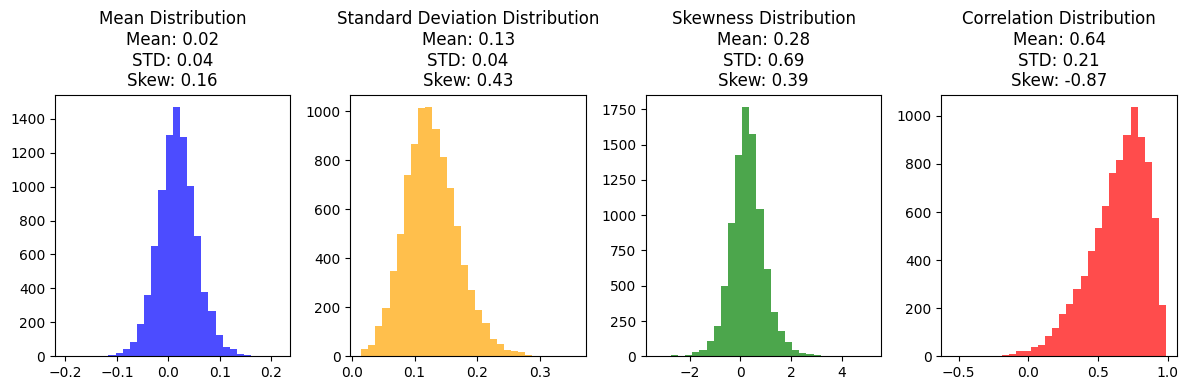

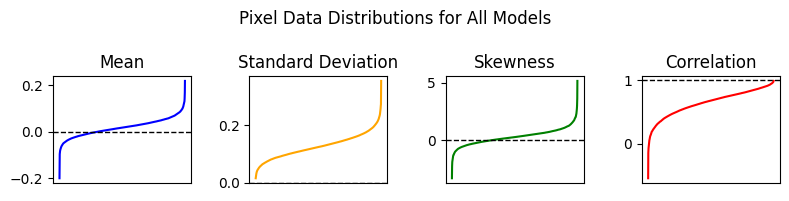

In [ ]:
#model num options = [1 2 3 4]
def pixelData_AllPics(model_num):
#define circular mask to only show important data
  def circular_mask(size, radius):
      y, x = np.ogrid[:size[0], :size[1]]
      center = (size[0] // 2, size[1] // 2)
      mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
      return mask

  with torch.no_grad():
    #create lists to hold relevant data
    mean_list = []
    std_list = []
    skew_list = []
    corr_list = []

    #iterate through all test data
    for cell_num in range(training_size, len(val_predict_rsp)):

      #used to visualize progress
      if cell_num % 1000 == 0:
        print(cell_num)
      if model_num ==1:
        pred_image = model1_pic(cell_num)
      elif model_num== 2:
        pred_image = model2_pic(cell_num)
      elif model_num == 3:
        pred_image = model3_pic(cell_num)
      elif model_num == 4:
        pred_image = model4_pic(cell_num)
      else:
        print("Please Try a integer between 1 and 4 inclusive")
        return None
      radius = 22
      # Load images and predicted images
      image1 = origin_pic(cell_num)
      image2 = pred_image

      # Create circular masks for both images
      mask1 = circular_mask(image1.shape, radius)
      mask2 = circular_mask(image2.shape, radius)

      # Convert the masks to binary masks (0s and 1s)
      binary_mask1 = mask1.astype(np.uint8)
      binary_mask2 = mask2.astype(np.uint8)

      # Extract pixel values within the circular region using the binary masks
      pixels_image1 = image1[binary_mask1 == 1]
      pixels_image2 = image2[binary_mask2 == 1]

      # Compute mean of each set of pixels
      mean_image1 = np.mean(pixels_image1)
      mean_image2 = np.mean(pixels_image2)

      # Compute Pearson correlation coefficient
      numerator = np.sum((pixels_image1 - mean_image1) * (pixels_image2 - mean_image2))
      denominator = np.sqrt(np.sum((pixels_image1 - mean_image1)**2) * np.sum((pixels_image2 - mean_image2)**2))

      #find the difference in each pixel
      pixel_diff = pixels_image1 - pixels_image2

      #append important data to respective list
      mean_list.append(np.mean(pixel_diff))
      std_list.append(np.std(pixel_diff))
      skew_list.append(skew(pixel_diff))
      corr_list.append(numerator / denominator)

  fig, axs = plt.subplots(1, 4, figsize=(12, 6))
  # Plot histograms and include mean and skewness in titles
  axs[0].hist(mean_list, bins=30, color='blue', alpha=0.7)
  axs[0].set_title(f'Mean Distribution\nMean: {np.mean(mean_list):.2f}\nSTD: {np.std(mean_list):.2f}\nSkew: {skew(mean_list):.2f}')

  axs[1].hist(std_list, bins=30, color='orange', alpha=0.7)
  axs[1].set_title(f'Standard Deviation Distribution\nMean: {np.mean(std_list):.2f}\nSTD: {np.std(std_list):.2f}\nSkew: {skew(std_list):.2f}')

  axs[2].hist(skew_list, bins=30, color='green', alpha=0.7)
  axs[2].set_title(f'Skewness Distribution\nMean: {np.mean(skew_list):.2f}\nSTD: {np.std(skew_list):.2f}\nSkew: {skew(skew_list):.2f}')

  axs[3].hist(corr_list, bins=30, color='red', alpha=0.7)
  axs[3].set_title(f'Correlation Distribution\nMean: {np.mean(corr_list):.2f}\nSTD: {np.std(corr_list):.2f}\nSkew: {skew(corr_list):.2f}')

  plt.suptitle(f"Pixel Data Distributions for All Models")

  # Adjust layout and show
  plt.tight_layout()
  plt.show()

  # Create subplots for sorted values
  fig, axs = plt.subplots(1, 4, figsize=(8, 2))

  # Plot sorted values and highlight the indices of the best and worst for Mean
  sorted_mean = np.sort(mean_list)
  axs[0].plot(sorted_mean, 'blue')
  axs[0].set_title('Mean')

  # Plot horizontal line at y=0
  axs[0].axhline(0, color='black', linestyle='--', linewidth=1, label='y=0')
  axs[0].set_xticks([])
  # Plot sorted values and highlight the indices of the best and worst for Standard Deviation
  sorted_std = np.sort(std_list)
  axs[1].plot(sorted_std, 'orange')
  axs[1].set_title('Standard Deviation')

  # Plot horizontal line at y=0
  axs[1].axhline(0, color='black', linestyle='--', linewidth=1, label='y=0')
  axs[1].set_xticks([])
  # Plot sorted values and highlight the indices of the best and worst for Skewness
  sorted_skew = np.sort(skew_list)
  axs[2].plot(sorted_skew, 'green')
  axs[2].set_title('Skewness')
  axs[2].set_xticks([])
  # Plot horizontal line at y=0
  axs[2].axhline(0, color='black', linestyle='--', linewidth=1, label='y=0')

  # Plot sorted values and highlight the indices of the best and worst for Correlation
  sorted_corr = np.sort(corr_list)
  axs[3].plot(sorted_corr, 'red')
  axs[3].set_title('Correlation')
  axs[3].set_xticks([])
  # Plot horizontal line at y=1
  axs[3].axhline(1, color='black', linestyle='--', linewidth=1, label='y=1')



  # Adjust layout
  plt.tight_layout()

  # Show the plots
  plt.show()

#model number range 1-4
pixelData_AllPics(1)

####Get Top Photos Closest to A Certain Value
The list parameter dependent on the list in the previous block. Make sure to run this with the other one if you are looking to use it

In [ ]:
def get_m_closest_to_n(data, topm, target, model_num):
  # Find the indices of the top N smallest squared differences from the target correlation
  indices_of_closest_to_target = sorted(range(len(data)), key=lambda i: (data[i] - target)**2)[:topm]

  # Get the top N values closest to the target correlation
  values_closest_to_target = [data[i] for i in indices_of_closest_to_target]
  indices_of_closest_to_target = [index + 25000 for index in indices_of_closest_to_target]
  fig, axs = plt.subplots(len(indices_of_closest_to_target), 2, figsize=(4, len(indices_of_closest_to_target)*2))
  for i, val in enumerate(indices_of_closest_to_target):

    # Plot real_rsp_pair_pics
    axs[i, 0].imshow(origin_pic(val), cmap='gray')
    axs[i, 0].set_title(f'#{i+1} Real Image')
    axs[i, 0].axis('off')

    # Plot model prediction
    if model_num ==1:
      pred_image = model1_pic(val)
    elif model_num== 2:
      pred_image = model2_pic(val)
    elif model_num == 3:
      pred_image = model3_pic(val)
    elif model_num == 4:
      pred_image = model4_pic(val)
    axs[i, 1].imshow(pred_image, cmap='gray')
    axs[i, 1].set_title(f'#{i+1} Predicted Image')
    axs[i, 1].axis('off')

  # Adjust layout
  plt.tight_layout()

  # Show the subplot
  plt.show()

#target is the value we want to see. In this example, we show the top 5 images that have the correlation closest to 1
get_m_closest_to_n(corr_list, 5, 1, 1)

####Neuronal Data

In [ ]:
def neuralData_AllPics(model_num):
  #create lists to hold respective data
  mean_list = []
  std_list = []
  skew_list = []
  corr_list = []

  #iterate through list
  for cell_num in range(training_size, len(val_predict_rsp)):
    #used to visualize progress
    if cell_num % 1000 == 0:
      print(cell_num)

    #create images and responses
    if model_num ==1:
      pred_image = model1_pic(cell_num)
    elif model_num== 2:
      pred_image = model2_pic(cell_num)
    elif model_num == 3:
      pred_image = model3_pic(cell_num)
    elif model_num == 4:
      pred_image = model4_pic(cell_num)
    else:
      print("Please choose number between 1 and 4 inclusive")
      return None

    neurons_pred_image_response = np.array(net(torch.from_numpy(pred_image.reshape(1,1,50,50)).to(device)).cpu().flatten().detach())
    neurons_real_image_response = np.array(net(torch.from_numpy(real_rsp_pair_pics[cell_num].reshape(1, 1, 50, 50).astype(float)).to(device).float()).cpu().flatten().detach())

    #calculate difference between each pixel
    difference = neurons_pred_image_response - neurons_real_image_response

    #calculate correlation
    corr_coefficient,_ = pearsonr(neurons_pred_image_response, neurons_real_image_response)

    mean_list.append(np.mean(difference))
    std_list.append(np.std(difference))
    skew_list.append(skew(difference))
    corr_list.append(corr_coefficient)

  fig, axs = plt.subplots(1,4, figsize=(12, 4))

  # Plot histograms and include mean and skewness in titles
  axes = axs[0]
  axes.hist(mean_list, bins=30, color='blue', alpha=0.7)
  axes.set_title(f'Mean Distribution\nMean: {np.mean(mean_list):.2f}\nSTD: {np.std(mean_list):.2f}\nSkew: {skew(mean_list):.2f}')
  axes = axs[1]
  axes.hist(std_list, bins=30, color='orange', alpha=0.7)
  axes.set_title(f'Standard Deviation Distribution\nMean: {np.mean(std_list):.2f}\nSTD: {np.std(std_list):.2f}\nSkew: {skew(std_list):.2f}')
  axes = axs[2]
  axes.hist(skew_list, bins=30, color='green', alpha=0.7)
  axes.set_title(f'Skewness Distribution\nMean: {np.mean(skew_list):.2f}\nSTD: {np.std(skew_list):.2f}\nSkew: {skew(skew_list):.2f}')
  axes = axs[3]
  axes.hist(corr_list, bins=30, color='red', alpha=0.7)
  axes.set_title(f'Correlation Distribution\nMean: {np.mean(corr_list):.2f}\nSTD: {np.std(corr_list):.2f}\nSkew: {skew(corr_list):.2f}')
  axes.suptitle(f"Neural Data for Model {model_num}")

  # Adjust layout
  plt.tight_layout()

  plt.show()

neuralData_AllPics(4)

25000


KeyboardInterrupt: ignored

###Data Per Picture Per Model
Inputs are always image number (cell_num) and model (model_num)

####Pixel-By-Pixel Per Cell

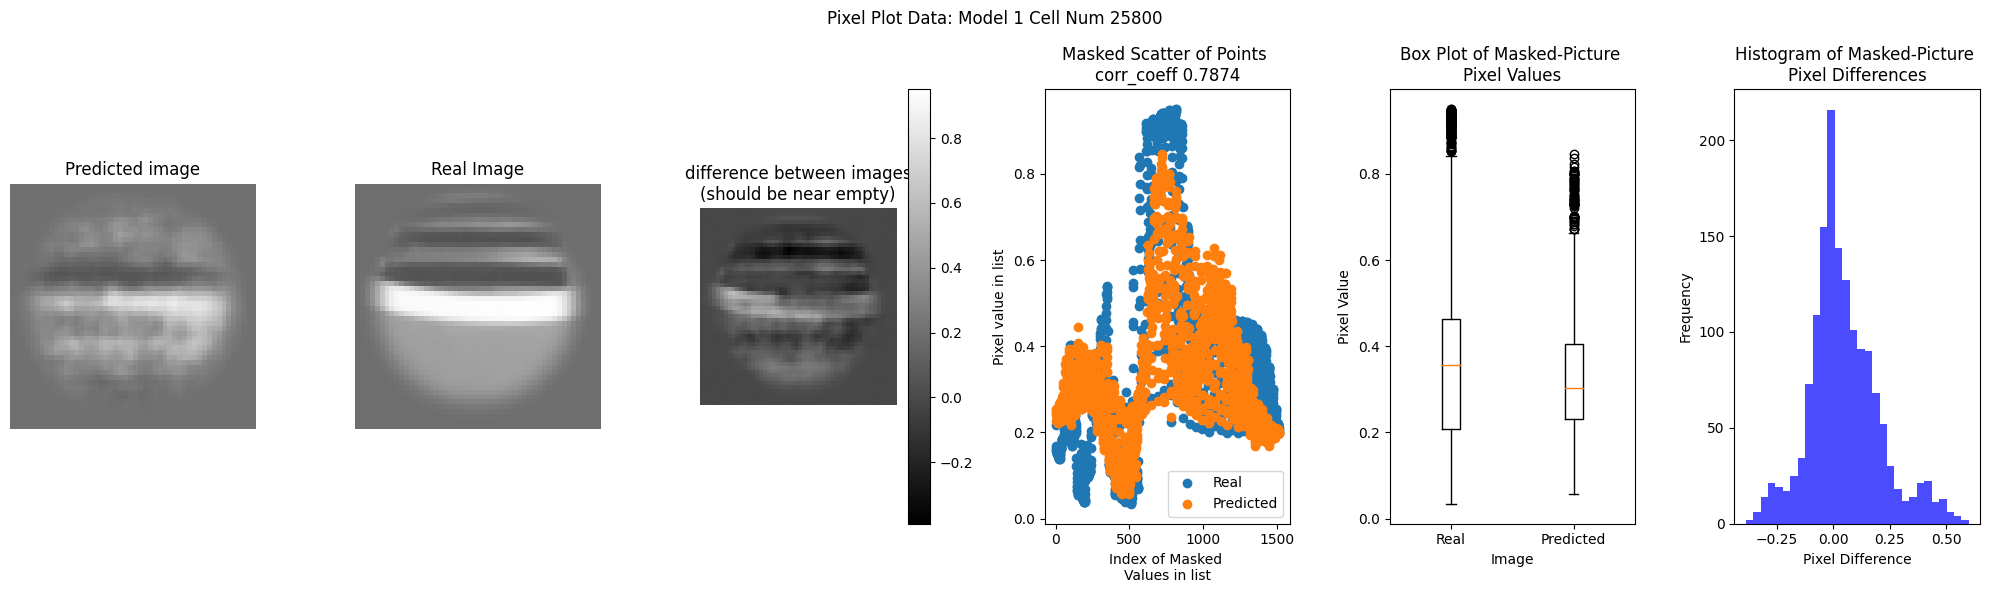

In [ ]:
#define a circular mask

def circular_mask(size, radius):
    y, x = np.ogrid[:size[0], :size[1]]
    center = (size[0] // 2, size[1] // 2)
    mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
    return mask

def compute_pearson_correlation(cell_num, model_num):
    radius = 22

    # Load your images (replace 'image1_path.jpg' and 'image2_path.jpg' with your actual file paths)
    image1 = origin_pic(cell_num)
    if model_num ==1:
      pred_image = model1_pic(cell_num)
    elif model_num== 2:
      pred_image = model2_pic(cell_num)
    elif model_num == 3:
      pred_image = model3_pic(cell_num)
    elif model_num == 4:
      pred_image = model4_pic(cell_num)
    # Create circular masks for both images
    mask1 = circular_mask(image1.shape, radius)
    mask2 = circular_mask(pred_image.shape, radius)

    # Convert the masks to binary masks (0s and 1s)
    binary_mask1 = mask1.astype(np.uint8)
    binary_mask2 = mask2.astype(np.uint8)

    # Extract pixel values within the circular region using the binary masks
    pixels_image1 = image1[binary_mask1 == 1]
    pixels_image2 = pred_image[binary_mask2 == 1]

    # Compute mean of each set of pixels
    mean_image1 = np.mean(pixels_image1)
    mean_image2 = np.mean(pixels_image2)

    plt.subplot(1, 6, 4)
    plt.scatter(range(len(pixels_image1.flatten())),pixels_image1.flatten())
    plt.scatter(range(len(pixels_image2.flatten())), pixels_image2.flatten())

    # Compute Pearson correlation coefficient
    numerator = np.sum((pixels_image1 - mean_image1) * (pixels_image2 - mean_image2))
    denominator = np.sqrt(np.sum((pixels_image1 - mean_image1)**2) * np.sum((pixels_image2 - mean_image2)**2))
    correlation_coefficient = numerator / denominator

    plt.xlabel('Index of Masked \nValues in list')
    plt.ylabel('Pixel value in list')
    plt.title(f'Masked Scatter of Points \ncorr_coeff {correlation_coefficient:.04}')
    plt.legend(["Real", "Predicted"])

    plt.subplot(1, 6,5)
    plt.boxplot([pixels_image1.flatten(), pixels_image2.flatten()], labels=['Real', 'Predicted'])
    plt.title('Box Plot of Masked-Picture \nPixel Values')
    plt.xlabel('Image')
    plt.ylabel('Pixel Value')

    # Histogram of pixel differences
    pixel_diff = pixels_image1 - pixels_image2
    plt.subplot(1, 6, 6)
    plt.hist(pixel_diff, bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of Masked-Picture \nPixel Differences')
    plt.xlabel('Pixel Difference')
    plt.ylabel('Frequency')

def pixelData_perCell(cell_num, model_num):
  if model_num ==1:
    pred_image = model1_pic(cell_num)
  elif model_num== 2:
    pred_image = model2_pic(cell_num)
  elif model_num == 3:
    pred_image = model3_pic(cell_num)
  elif model_num == 4:
    pred_image = model4_pic(cell_num)

  diff = origin_pic(cell_num) - pred_image
  vmin = min(origin_pic(cell_num).min(), pred_image.min(), diff.min())
  vmax = max(origin_pic(cell_num).max(), pred_image.max(), diff.max())
  plt.figure(figsize = (20,6))

  plt.subplot(1,6, 1)
  plt.imshow(pred_image, vmin=vmin, vmax=vmax, cmap = 'gray')
  plt.title(f"Predicted image")
  plt.axis('off')

  plt.subplot(1,6, 2)
  plt.imshow(origin_pic(cell_num).reshape(50, 50), vmin=vmin, vmax=vmax, cmap = 'gray')
  plt.title(f"Real Image")

  plt.axis('off')

  plt.subplot(1,6, 3)
  plt.imshow(diff, vmin=vmin, vmax=vmax, cmap = 'gray')
  plt.title(f"difference between images\n(should be near empty)")
  plt.axis('off')

  cbar = plt.colorbar()
  compute_pearson_correlation(cell_num, model_num)

  plt.suptitle(f"Pixel Plot Data: Model {model_num} Cell Num {cell_num}")

  plt.tight_layout()
  plt.show()

pixelData_perCell(25800, 1)

####Neural Data Per Cell

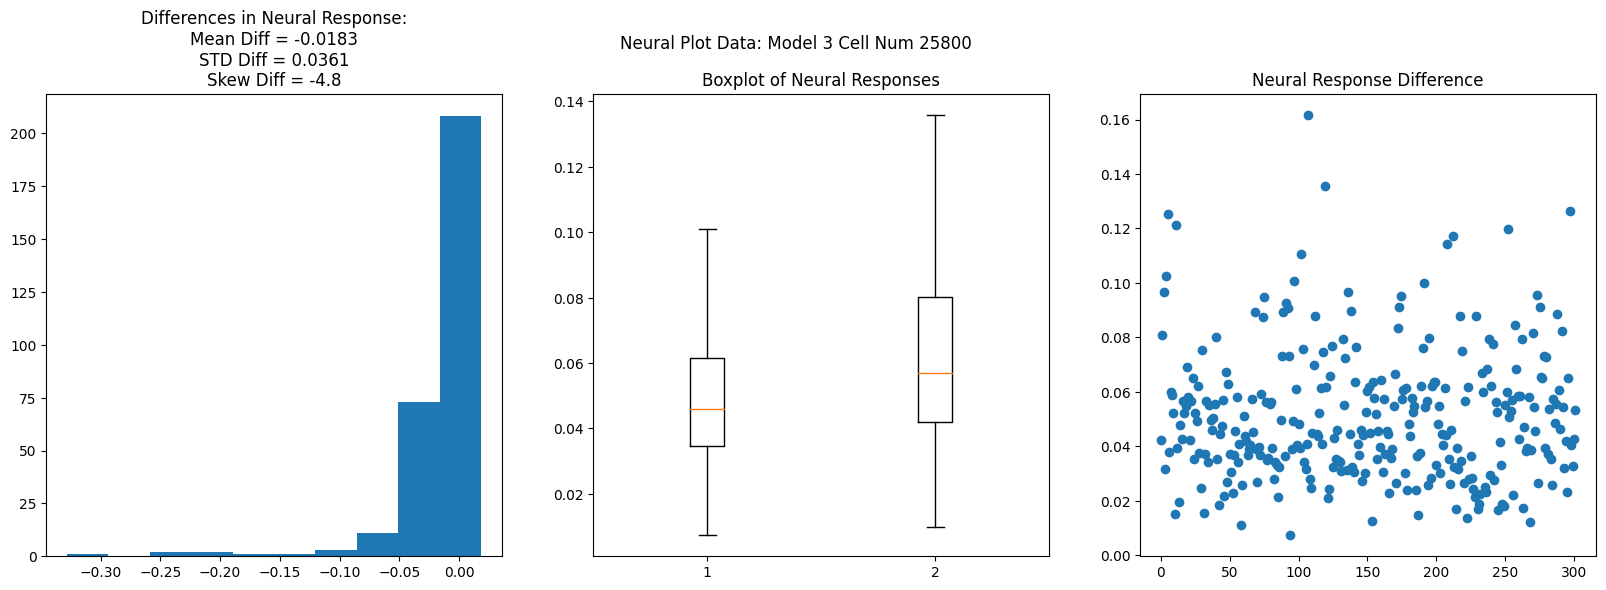

In [ ]:
def neurData_perCell(cell_num, model_num):
  orig_image = origin_pic(cell_num)
  if model_num == 1:
    pred_image = model1_pic(cell_num)
  elif model_num == 2:
    pred_image = model2_pic(cell_num)
  elif model_num == 3:
    pred_image = model3_pic(cell_num)
  elif model_num == 4:
    pred_image = model4_pic(cell_num)
  neurons_pred_image_response = np.array(net(torch.from_numpy(pred_image.reshape(1,1,50,50)).to(device)).cpu().flatten().detach())
  neurons_real_image_response = np.array(net(torch.from_numpy(orig_image.reshape(1, 1, 50, 50).astype(float)).to(device).float()).cpu().flatten().detach())

  difference = neurons_pred_image_response - neurons_real_image_response

  mean_diff =  np.mean(difference)
  std_diff = np.std(difference)
  skew_diff = skew(difference)

  plt.figure(figsize = (20,6))
  #generating histogram of neuron differences
  plt.subplot(1,3, 1)
  plt.hist(difference)
  plt.title(f"Differences in Neural Response:\nMean Diff = {mean_diff:.3}\nSTD Diff = {std_diff:.3}\nSkew Diff = {skew_diff:.3}")

  #generating boxplot of neuron responses
  plt.subplot(1,3, 2)
  plt.boxplot([neurons_pred_image_response,neurons_real_image_response], showfliers = False ) #outliers not shown
  plt.title(f"Boxplot of Neural Responses")

  #generating scatterplot of neuron differences
  plt.subplot(1,3, 3)
  plt.scatter(range(len(difference)),neurons_pred_image_response)
  plt.title(f"Neural Response Difference")

  plt.suptitle(f"Neural Plot Data: Model {model_num} Cell Num {cell_num}")
  plt.show()



neurData_perCell(25800, 3)

###Mean Squared Error


In [ ]:
mse_pic_model = []
mse_neu_model = []

def mse(model_num):
  for cell_num in range(training_size, len(val_predict_rsp)):
    if cell_num % 100 == 0:
      print(cell_num)
    if model_num ==1:
      pred_image = model1_pic(cell_num)
    elif model_num== 2:
      pred_image = model2_pic(cell_num)
    elif model_num == 3:
      pred_image = model3_pic(cell_num)
    elif model_num == 4:
      pred_image = model4_pic(cell_num)
    else:
      print("Please Try a integer between 1 and 4 inclusive")
      break
    mse_pic_model.append(mean_squared_error(origin_pic(cell_num).flatten(), pred_image.flatten()))
    mse_neu_model.append(mean_squared_error(origin_neu(cell_num).flatten(), model1_neu(cell_num).flatten()))

  print(np.mean(mse_pic_model))
  print("-------")
  print(np.mean(mse_neu_model))
mse(4)

25000


KeyboardInterrupt: ignored